# Data Collection

In [ ]:
# TODO: Specify a hyperparameter for how large the spatial patches will be (should be a x a)
# ERA5 Reanalysis Maps:
# https://cds.climate.copernicus.eu/datasets (create account)
# https://colab.research.google.com/drive/1LDnYkTQ2968sqtaRRFZUraEk8m0o1bGU?usp=sharing (proposal phase colab)
# https://github.com/leobix/hurricast/blob/deploy/misc/notebooks/vision_processing.ipynb (what they have for data)

In [ ]:
!pip install cdsapi numpy netCDF4 matplotlib cartopy fiona

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 71.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 92.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 64.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 46.6 MB/s eta 0:00:00
  Created wheel for multiurl: filename=multiurl-0.3.3-py3-none-any.whl size=21230 sha256=83b7025602f9863fed433b0fe5a01aeb65e21938769f3f06430af4e384a277f5
  Stored in directory: /root/.cache/pip/wheels/be/05/e0/65a6edb0a000498aeaefbadd80228bf5ed1bdbb82840ca1692
Successfully built multiurl


In [ ]:
!mkdir data

# Download the dataset shapefiles [try again later if (server) error occurs]
!wget https://www.ncei.noaa.gov/data/international-best-track-archive-for-climate-stewardship-ibtracs/v04r01/access/shapefile/IBTrACS.ALL.list.v04r01.points.zip
!unzip IBTrACS.ALL.list.v04r01.points.zip -d "data" # Point data

!wget https://www.ncei.noaa.gov/data/international-best-track-archive-for-climate-stewardship-ibtracs/v04r01/access/shapefile/IBTrACS.ALL.list.v04r01.lines.zip
!unzip IBTrACS.ALL.list.v04r01.lines.zip -d "data" # Polygon data


--2024-12-13 17:08:36--  https://www.ncei.noaa.gov/data/international-best-track-archive-for-climate-stewardship-ibtracs/v04r01/access/shapefile/IBTrACS.ALL.list.v04r01.points.zip
Resolving www.ncei.noaa.gov (www.ncei.noaa.gov)... 205.167.25.177, 205.167.25.178, 205.167.25.168, ...
Connecting to www.ncei.noaa.gov (www.ncei.noaa.gov)|205.167.25.177|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 41315639 (39M) [application/zip]
Saving to: ‘IBTrACS.ALL.list.v04r01.points.zip’

IBTrACS.ALL.list.v0 100%[===================>]  39.40M  10.3MB/s    in 3.8s    

2024-12-13 17:08:41 (10.3 MB/s) - ‘IBTrACS.ALL.list.v04r01.points.zip’ saved [41315639/41315639]

Archive:  IBTrACS.ALL.list.v04r01.points.zip
  inflating: data/IBTrACS.ALL.list.v04r01.points.dbf  
  inflating: data/IBTrACS.ALL.list.v04r01.points.prj  
  inflating: data/IBTrACS.ALL.list.v04r01.points.shp  
  inflating: data/IBTrACS.ALL.list.v04r01.points.shx  
--2024-12-13 17:08:50--  https://www.ncei.noaa.gov

In [ ]:
# Import the dataset shapefiles from local machine (assuming it exists in these file paths)
from google.colab import drive
drive.mount("/content/drive")

!mkdir data
!unzip /content/drive/MyDrive/data/IBTrACS.ALL.list.v04r01.points.zip -d "data" # Point data
!unzip /content/drive/MyDrive/data/IBTrACS.ALL.list.v04r01.lines.zip -d "data" # Polygon data

Mounted at /content/drive
mkdir: cannot create directory ‘data’: File exists
unzip:  cannot find or open /content/drive/MyDrive/data/IBTrACS.ALL.list.v04r01.points.zip, /content/drive/MyDrive/data/IBTrACS.ALL.list.v04r01.points.zip.zip or /content/drive/MyDrive/data/IBTrACS.ALL.list.v04r01.points.zip.ZIP.
unzip:  cannot find or open /content/drive/MyDrive/data/IBTrACS.ALL.list.v04r01.lines.zip, /content/drive/MyDrive/data/IBTrACS.ALL.list.v04r01.lines.zip.zip or /content/drive/MyDrive/data/IBTrACS.ALL.list.v04r01.lines.zip.ZIP.


In [ ]:
point_filepath = "data/IBTrACS.ALL.list.v04r01.points.shp"
polygon_filepath = "data/IBTrACS.ALL.list.v04r01.lines.shp"

In [ ]:
import cdsapi
import fiona
import numpy as np
import netCDF4
import matplotlib.pyplot as plt
from datetime import datetime
import os
import shutil
import threading
import warnings; warnings.simplefilter('ignore')

ModuleNotFoundError: No module named 'cdsapi'

In [ ]:
# Filter data between the years 1990 and 2023 along with wind speed >= 35kt
with fiona.open(point_filepath) as src:
  filtered_points = [x for x in src if
                     int(x["properties"]["ISO_TIME"][:4]) >= 1990 and
                     int(x["properties"]["ISO_TIME"][:4]) <= 2023 and
                     x["properties"]["USA_WIND"] and
                     int(x["properties"]["USA_WIND"]) >= 35]

with fiona.open(polygon_filepath) as src:
  filtered_polygons = [x for x in src if
                       int(x["properties"]["ISO_TIME"][:4]) >= 1990 and
                       int(x["properties"]["ISO_TIME"][:4]) <= 2023 and
                       x["properties"]["USA_WIND"] and
                       int(x["properties"]["USA_WIND"]) >= 35]

In [ ]:
import itertools

key_point_features = ["BASIN", "LAT", "LON", "ISO_TIME", "USA_WIND", "USA_PRES",
                      "USA_STATUS", "NATURE", "STORM_SPD", "STORM_DR", "SID"]
point_features_itos = dict(enumerate(key_point_features)) # a mapping of index => feature (string)
point_features_stoi = {feature:index for index, feature in point_features_itos.items()} # a mapping of feature => its index
sid_index = point_features_stoi["SID"]

# Filter key features stated in the proposal/report
point_data = [[x["properties"][feature] for feature in key_point_features] for x in filtered_points]
point_data = [features for features in point_data if None not in features] # filter records containing None values
point_data = [list(group) for _, group in itertools.groupby(point_data, lambda x: x[sid_index])] # group points together by SID
point_data = [features[:9] for features in point_data if len(features) >= 9]
targets = [features[8] for features in point_data]
point_data = [features[:8] for features in point_data]
print(len(point_data))
[[timestep.pop(sid_index) for timestep in storm] for storm in point_data] # remove SID from each point since it is no longer needed

key_polygon_features = ["LAT", "LON", "SID"]

NameError: name 'filtered_points' is not defined

In [ ]:
# A list of all the basins in the data set; assign a unique identifier for each of these basins
basins = sorted(["NA", "EP", "NI", "WP", "SP", "SI", "SA"])
basins_itos = dict(enumerate(basins)) # a mapping of index => basin (string)
basins_stoi = {basin:index for index, basin in basins_itos.items()} # a mapping of basin => its index

# A list of all the system statuses in the data set; assign a unique identifier for each of these system statuses
statuses = sorted(["DB", "TD", "TS", "TY", "ST", "TC", "HU", "HR", "SD", "SS", "EX", "PT", "IN", "DS", "LO", "WV", "ET", "MD", "XX"])
statuses_itos = dict(enumerate(statuses)) # a mapping of index => status (string)
statuses_stoi = {status:index for index, status in statuses_itos.items()} # a mapping of status => its index

# A list of all the storm types in the data set; assign a unique identifier for each of these storm types
natures = sorted(["DS", "TS", "ET", "SS", "NR", "MX"])
natures_itos = dict(enumerate(natures)) # a mapping of index => nature (string)
natures_stoi = {nature:index for index, nature in natures_itos.items()} # a mapping of nature => its index

def generate_one_hot_encoding(key, stoi, lst):
  ''' This function takes a basin/status and returns a new list representing its respective one-hot encoding '''
  return [1 if i == stoi[key] else 0 for i in range(len(lst))]

In [ ]:
for storm in point_data:
  for timestep in storm:
    print(timestep)
    print("==================================================")
    print(basins)
    print(generate_one_hot_encoding(timestep[point_features_stoi["BASIN"]], basins_stoi, basins))
    print("==================================================")
    print(statuses)
    print(generate_one_hot_encoding(timestep[point_features_stoi["USA_STATUS"]], statuses_stoi, statuses))
    print("==================================================")
    print(natures)
    print(generate_one_hot_encoding(timestep[point_features_stoi["NATURE"]], natures_stoi, natures))
    break
  break

['EP', 11.7, -105.5, '1990-05-14 00:00:00', 35, 1005, 'TS', 'TS', 12, 285]
['EP', 'NA', 'NI', 'SA', 'SI', 'SP', 'WP']
[1, 0, 0, 0, 0, 0, 0]
['DB', 'DS', 'ET', 'EX', 'HR', 'HU', 'IN', 'LO', 'MD', 'PT', 'SD', 'SS', 'ST', 'TC', 'TD', 'TS', 'TY', 'WV', 'XX']
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
['DS', 'ET', 'MX', 'NR', 'SS', 'TS']
[0, 0, 0, 0, 0, 1]


In [ ]:
# A list of all the basins in the data set; assign a unique identifier for each of these basins
basins = sorted(["NA", "EP", "NI", "WP", "SP", "SI", "SA"])
basins_itos = dict(enumerate(basins)) # a mapping of index => basin (string)
basins_stoi = {basin:index for index, basin in basins_itos.items()} # a mapping of basin => its index

# A list of all the system statuses in the data set; assign a unique identifier for each of these system statuses
statuses = sorted(["DB", "TD", "TS", "TY", "ST", "TC", "HU", "HR", "SD", "SS", "EX", "PT", "IN", "DS", "LO", "WV", "ET", "MD", "XX"])
statuses_itos = dict(enumerate(statuses)) # a mapping of index => status (string)
statuses_stoi = {status:index for index, status in statuses_itos.items()} # a mapping of status => its index

# A list of all the storm types in the data set; assign a unique identifier for each of these storm types
natures = sorted(["DS", "TS", "ET", "SS", "NR", "MX"])
natures_itos = dict(enumerate(natures)) # a mapping of index => nature (string)
natures_stoi = {nature:index for index, nature in natures_itos.items()} # a mapping of nature => its index

def generate_one_hot_encoding(key, stoi, lst):
  ''' This function takes a basin/status and returns a new list representing its respective one-hot encoding '''
  return [1 if i == stoi[key] else 0 for i in range(len(lst))]

In [ ]:
min_len = 30000
max_len = -1
min_pressure = 30000
max_pressure = -1

total_us_wind = np.array([((np.array(np_ify))[:][:, 4]).astype(int) for np_ify in point_data])
for storm in point_data:
  #print(storm)
  np_ify = np.array(storm)
  if len(storm) > max_len:
    max_len = len(storm)
  elif len(storm) < min_len:
    min_len = len(storm)
  for step in storm:
    if step[5] > max_pressure:
      max_pressure = step[5]
    elif step[5] < min_pressure:
      min_pressure = step[5]
print(min_len)
print(max_len)
print(min_pressure)
print(max_pressure)

print(total_us_wind)
print(np.mean(total_us_wind))
print(np.std(total_us_wind))

8
8
927
1016
[[35 35 35 ... 40 45 50]
 [35 40 45 ... 55 60 63]
 [35 35 35 ... 38 40 40]
 ...
 [35 35 35 ... 43 45 45]
 [35 35 35 ... 35 35 35]
 [35 35 35 ... 45 50 53]]
42.852560975609755
8.166930239628897


In [ ]:
def encode(period, val):
    return [np.sin(2 * np.pi * val/period), np.cos(2 * np.pi * val/period)]

In [ ]:
home_dir = os.path.expanduser("~")  # Get the home directory
cdsapirc_path = os.path.join(home_dir, ".cdsapirc")

# Your CDS API credentials
uid = "fc2fd2f9-8fd2-4b4c-896a-3388f46d304c"  # Replace with your UID
api_key = "87f59afa-47d9-4cb0-ab33-787f3110d917"

# Write the credentials to the .cdsapirc file
with open(cdsapirc_path, "w") as f:
    f.write(f"url: https://cds.climate.copernicus.eu/api\n")
    f.write(f"key: {api_key}\n")

print(f"Configuration file created at: {cdsapirc_path}")

Configuration file created at: /root/.cdsapirc


General idea: Get appropriate data from IBTRaCS. After cleaning, access the ERA5 data given the queryable values from IBTRaCS in the ERA5 API. partition the
subsequent data into chunks of size k x k for each variable we choose to exam in
our model

Method to get our spatial patches. This returns k*k k x k patches. So for a 25 by 25 set of data this would result in 25 5 x 5 patches (hopefully this is intuitive). Because our patch features are flattened this results in a shape (k, k) but there's an example below to show that this is not just recreating the input

In [ ]:
def partition_patches(input, k=5):
  dim_x, dim_y = input.shape[0], input.shape[1]
  if dim_x % k != 0 and dim_y % k != 0:
    raise Exception("Invalid partition value")
  indices_x = [i for i in range(0, dim_x, k)]
  indices_y = [i for i in range(0, dim_y, k)]

  y_split = np.split(input, k, axis=1)
  res = []
  for y_chunk in y_split:
    for x_chunk in np.array_split(y_chunk, k, axis=0):
      res.append(x_chunk.flatten())
  np_ify = np.array(res)
  return np_ify

Gets the total latitude and logitude ranges to encapsulate our area. Sourced from https://github.com/leobix/hurricast/blob/deploy/misc/notebooks/vision_processing.ipynb

In [ ]:
def get_area(lat, lon, grid_size, e = 0.008):
    '''
    input : center of the storm,
    output: returns a centered squared grid of size grid_size degrees
    '''
    val = grid_size // 2
    return [lat + val + e, lon - val, lat - val - e, lon + val]

Set up the ERA5 API to retrieve the appropriate ERA5 data.

In [ ]:
c = cdsapi.Client()
variables = ["relative_humidity", "temperature", "u_component_of_wind", "v_component_of_wind", "vorticity", "geopotential"]

hurricanes_basefilepath = "/content/drive/MyDrive/hurricanes"
if not os.path.isdir(hurricanes_basefilepath):
  os.makedirs(hurricanes_basefilepath)

def recover_hurricane_era5(query_list, hurricane_num, thread_num, grid_size=25):
  datetime_val = query_list[0]
  pressure = query_list[1]
  longitude = float(query_list[2])
  latitude = float(query_list[3])
  converted = datetime.fromisoformat(datetime_val)

  hurricanes_basefilepath = "/content/drive/MyDrive/hurricanes/hurricane_{0}".format(hurricane_num)
  hurricane_filepath = "hurricanes/hurricane_{0}/timestep_{1}.nc".format(hurricane_num, thread_num)

  c.retrieve("reanalysis-era5-pressure-levels", {
    "product_type": "reanalysis",
    "variable": variables,
    "pressure_level": pressure,
    "year": converted.strftime("%Y"),
    "month": converted.strftime("%m"),
    "day": converted.strftime("%d"),
    "area": get_area(latitude, longitude, grid_size), # North, West, South, East. Default: global
    "grid": [1.0, 1.0], # latitude/longitude grid: east-west (longitude) and north-south resolution (latitude). Default: 0.25 x 0.25
    "time": converted.strftime("%H") + ":00",
    "format": "netcdf",
  }, hurricane_filepath)
  shutil.copy(hurricane_filepath, hurricanes_basefilepath)

def form_era5_data(point_data_record, hurricane_num):
  path = "hurricanes/hurricane_{0}".format(hurricane_num)
  applicable_era5_pressures = [925, 950, 975, 1000]

  thread_list = []
  for i, step in enumerate(point_data_record):
    closest = min(applicable_era5_pressures, key=(lambda x : abs(x - int(step[5]))))
    thread_list.append(threading.Thread(target=recover_hurricane_era5, args=([step[3], closest, step[2], step[1]], hurricane_num, i)))

  if not os.path.exists(path):
    os.mkdir(path)
  hurricanes_basefilepath = "/content/drive/MyDrive/hurricanes/hurricane_{0}".format(hurricane_num)
  if not os.path.isdir(hurricanes_basefilepath):
    os.makedirs(hurricanes_basefilepath)

  for t in thread_list:
    t.start()
  for t in thread_list:
    t.join()

2024-12-11 01:57:11,609 INFO [2024-09-28T00:00:00] **Welcome to the New Climate Data Store (CDS)!** This new system is in its early days of full operations and still undergoing enhancements and fine tuning. Some disruptions are to be expected. Your 
[feedback](https://jira.ecmwf.int/plugins/servlet/desk/portal/1/create/202) is key to improve the user experience on the new CDS for the benefit of everyone. Thank you.
INFO:datapi.legacy_api_client:[2024-09-28T00:00:00] **Welcome to the New Climate Data Store (CDS)!** This new system is in its early days of full operations and still undergoing enhancements and fine tuning. Some disruptions are to be expected. Your 
[feedback](https://jira.ecmwf.int/plugins/servlet/desk/portal/1/create/202) is key to improve the user experience on the new CDS for the benefit of everyone. Thank you.
2024-12-11 01:57:11,614 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
INFO:datapi.le

Combine both the IBTrACS data and the ERA5 data together and process the combined data.

In [ ]:
def form_processed_data(point_data_record, wind_col, speed_col, pressure_col):
  res = []
  for i, step in enumerate(point_data_record):
    datetime_val = step[3]
    converted = datetime.strptime(datetime_val, "%Y-%m-%d %H:%M:%S")
    year = converted.year
    month = encode(12, converted.month)
    hour = encode(24, converted.hour)
    normalized_wind = (int(step[4]) - np.mean(wind_col))/np.std(wind_col)
    normalized_speed = (int(step[8]) - np.mean(speed_col))/np.std(speed_col)
    normalized_pressure = (int(step[5]) - np.min(pressure_col)) / (np.max(pressure_col) - np.min(pressure_col))
    basin_onehot = generate_one_hot_encoding(timestep[point_features_stoi["BASIN"]], basins_stoi, basins)
    status_onehot = generate_one_hot_encoding(timestep[point_features_stoi["USA_STATUS"]], statuses_stoi, statuses)
    nature_onehot = generate_one_hot_encoding(timestep[point_features_stoi["NATURE"]], natures_stoi, natures)
    shapefile_data = basin_onehot + [float(step[1]), float(step[2]), year] + month + hour + [normalized_wind, normalized_pressure] + status_onehot + nature_onehot + [normalized_speed, float(step[9])]
    res.append(np.array(shapefile_data))
  return res

In [ ]:
def process_data(point_data):
  if not os.path.exists('hurricanes'):
    os.mkdir('hurricanes')
  total_us_wind = np.array([((np.array(np_ify))[:][:, 4]).astype(int) for np_ify in point_data])
  total_pressure = np.array([((np.array(np_ify))[:][:, 5]).astype(int) for np_ify in point_data])
  total_speed = np.array([((np.array(np_ify))[:][:, 8]).astype(int) for np_ify in point_data])
  total_data = []
  for storm in point_data:
    total_data.append(form_processed_data(storm, total_us_wind, total_speed, total_pressure))
  for i, storm in enumerate(point_data):
    if (i < 500):
      continue
    form_era5_data(storm, i)

In [ ]:
result = process_data(point_data)
with open('processed.txt', 'w+') as f:

    # write elements of list
    for items in result:
        f.write('%s\n' %items)

    print("File written successfully")


# close the file
f.close()

2024-12-11 01:57:19,863 WARNING [2024-10-10T00:00:00] The final validated ERA5 differs from ERA5T from July 2024 until further notice - please refer to our
[Forum announcement](https://forum.ecmwf.int/t/final-validated-era5-product-to-differ-from-era5t-in-july-2024/6685)
for details and watch it for further updates on this.
[Forum announcement](https://forum.ecmwf.int/t/final-validated-era5-product-to-differ-from-era5t-in-july-2024/6685)
for details and watch it for further updates on this.
2024-12-11 01:57:19,869 INFO Request ID is 5880aa81-32cf-45bd-9cf1-38ff7edca6cc
INFO:datapi.legacy_api_client:Request ID is 5880aa81-32cf-45bd-9cf1-38ff7edca6cc
2024-12-11 01:57:20,020 WARNING [2024-10-10T00:00:00] The final validated ERA5 differs from ERA5T from July 2024 until further notice - please refer to our
[Forum announcement](https://forum.ecmwf.int/t/final-validated-era5-product-to-differ-from-era5t-in-july-2024/6685)
for details and watch it for further updates on this.
[Forum announceme

8ae204edba337acfce2cf3cc00f67e3f.nc:   0%|          | 0.00/83.9k [00:00<?, ?B/s]

2024-12-11 01:57:42,100 INFO status has been updated to running
INFO:datapi.legacy_api_client:status has been updated to running
2024-12-11 01:57:53,519 INFO status has been updated to running
INFO:datapi.legacy_api_client:status has been updated to running
2024-12-11 01:57:53,704 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful


f74285feb451f2bac4c7dbd39b571340.nc:   0%|          | 0.00/84.1k [00:00<?, ?B/s]

2024-12-11 01:58:10,849 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful
2024-12-11 01:58:11,093 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful


2b26e1802129ad95b2cb714beb766527.nc:   0%|          | 0.00/83.7k [00:00<?, ?B/s]

ce76d5e523a04d215e9c66032584e946.nc:   0%|          | 0.00/84.0k [00:00<?, ?B/s]

2024-12-11 01:58:37,148 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful


2e1355c31e5ba8e198df4224b8d971af.nc:   0%|          | 0.00/84.0k [00:00<?, ?B/s]

2024-12-11 01:58:38,304 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful
2024-12-11 01:58:38,666 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful
2024-12-11 01:58:38,714 INFO status has been updated to running
INFO:datapi.legacy_api_client:status has been updated to running


42cc74475f9d785063c222b26d35f23e.nc:   0%|          | 0.00/84.0k [00:00<?, ?B/s]

93f6771594e39f5e7d07e4dce5ada56c.nc:   0%|          | 0.00/84.0k [00:00<?, ?B/s]

2024-12-11 01:59:17,320 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful


6ee2da07b5bb7163e2a4adec29ff89a0.nc:   0%|          | 0.00/83.9k [00:00<?, ?B/s]

2024-12-11 01:59:19,203 WARNING [2024-10-10T00:00:00] The final validated ERA5 differs from ERA5T from July 2024 until further notice - please refer to our
[Forum announcement](https://forum.ecmwf.int/t/final-validated-era5-product-to-differ-from-era5t-in-july-2024/6685)
for details and watch it for further updates on this.
[Forum announcement](https://forum.ecmwf.int/t/final-validated-era5-product-to-differ-from-era5t-in-july-2024/6685)
for details and watch it for further updates on this.
2024-12-11 01:59:19,207 INFO Request ID is bb90ade3-0f29-4e09-a1ed-d5a1f72c45ee
INFO:datapi.legacy_api_client:Request ID is bb90ade3-0f29-4e09-a1ed-d5a1f72c45ee
2024-12-11 01:59:19,225 WARNING [2024-10-10T00:00:00] The final validated ERA5 differs from ERA5T from July 2024 until further notice - please refer to our
[Forum announcement](https://forum.ecmwf.int/t/final-validated-era5-product-to-differ-from-era5t-in-july-2024/6685)
for details and watch it for further updates on this.
[Forum announceme

917790eaf14700cd3a11833cb528f458.nc:   0%|          | 0.00/83.5k [00:00<?, ?B/s]

3d3891c2ee0818320daaa0814bf091d1.nc:   0%|          | 0.00/83.1k [00:00<?, ?B/s]

52e663938dc98aa5322f3f2866d0b1d.nc:   0%|          | 0.00/83.6k [00:00<?, ?B/s]

b60f9bd67cf98e7dd6d3a0cf07895fc5.nc:   0%|          | 0.00/83.3k [00:00<?, ?B/s]

2024-12-11 02:02:13,014 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful
2024-12-11 02:02:13,233 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful
2024-12-11 02:02:13,466 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful
2024-12-11 02:02:13,744 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful


7161e3b121b9afaf76ce342aa802fd89.nc:   0%|          | 0.00/83.4k [00:00<?, ?B/s]

24817d36e328d649f64bc695d8d4ea3c.nc:   0%|          | 0.00/83.1k [00:00<?, ?B/s]

8f1f6f2506886cb7e784a6a85eda14de.nc:   0%|          | 0.00/83.2k [00:00<?, ?B/s]

2de75d6b5d039958eae007f9718eacd4.nc:   0%|          | 0.00/83.3k [00:00<?, ?B/s]

2024-12-11 02:02:15,786 WARNING [2024-10-10T00:00:00] The final validated ERA5 differs from ERA5T from July 2024 until further notice - please refer to our
[Forum announcement](https://forum.ecmwf.int/t/final-validated-era5-product-to-differ-from-era5t-in-july-2024/6685)
for details and watch it for further updates on this.
[Forum announcement](https://forum.ecmwf.int/t/final-validated-era5-product-to-differ-from-era5t-in-july-2024/6685)
for details and watch it for further updates on this.
2024-12-11 02:02:15,799 INFO Request ID is 23687ad5-70aa-4f6d-a814-4830334b1dcd
INFO:datapi.legacy_api_client:Request ID is 23687ad5-70aa-4f6d-a814-4830334b1dcd
2024-12-11 02:02:15,893 WARNING [2024-10-10T00:00:00] The final validated ERA5 differs from ERA5T from July 2024 until further notice - please refer to our
[Forum announcement](https://forum.ecmwf.int/t/final-validated-era5-product-to-differ-from-era5t-in-july-2024/6685)
for details and watch it for further updates on this.
[Forum announceme

a5f56670e980699652e014f38f4724ca.nc:   0%|          | 0.00/84.1k [00:00<?, ?B/s]

2024-12-11 02:03:33,087 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful
2024-12-11 02:03:33,194 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful


b8c3de33c544eb98a26c82c52e0a049e.nc:   0%|          | 0.00/83.9k [00:00<?, ?B/s]

2024-12-11 02:03:33,892 INFO status has been updated to running
INFO:datapi.legacy_api_client:status has been updated to running


57c33533a6c843c8f2212d5e15bedf15.nc:   0%|          | 0.00/84.0k [00:00<?, ?B/s]

2024-12-11 02:04:11,934 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful
2024-12-11 02:04:11,949 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful
2024-12-11 02:04:12,026 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful
2024-12-11 02:04:12,561 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful


f53592dbcf4c7456eb9179fd17e62a91.nc:   0%|          | 0.00/83.9k [00:00<?, ?B/s]

f0c406fd7ece6a0b481116cbc8f2f084.nc:   0%|          | 0.00/83.9k [00:00<?, ?B/s]

3ed7f76859f73fd3506c7e1508eef6d9.nc:   0%|          | 0.00/83.9k [00:00<?, ?B/s]

305a0a8def7cbf47c26237e9d8dea27b.nc:   0%|          | 0.00/83.8k [00:00<?, ?B/s]

2024-12-11 02:05:15,170 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful


175bcc5c24970b1a4a8bddc033555982.nc:   0%|          | 0.00/84.1k [00:00<?, ?B/s]

2024-12-11 02:05:17,360 WARNING [2024-10-10T00:00:00] The final validated ERA5 differs from ERA5T from July 2024 until further notice - please refer to our
[Forum announcement](https://forum.ecmwf.int/t/final-validated-era5-product-to-differ-from-era5t-in-july-2024/6685)
for details and watch it for further updates on this.
[Forum announcement](https://forum.ecmwf.int/t/final-validated-era5-product-to-differ-from-era5t-in-july-2024/6685)
for details and watch it for further updates on this.
2024-12-11 02:05:17,370 INFO Request ID is 899af967-d50e-4230-8bb3-c2f98b0ddef4
INFO:datapi.legacy_api_client:Request ID is 899af967-d50e-4230-8bb3-c2f98b0ddef4
2024-12-11 02:05:17,572 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2024-12-11 02:05:17,707 WARNING [2024-10-10T00:00:00] The final validated ERA5 differs from ERA5T from July 2024 until further notice - please refer to our
[Forum announcement](https://forum.ecmwf.int/t/final-val

4e689215e1eace3a9e0b6dba499ef3df.nc:   0%|          | 0.00/83.9k [00:00<?, ?B/s]

2024-12-11 02:05:40,020 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful


ab22da031684e687097cee80d26fd98e.nc:   0%|          | 0.00/84.0k [00:00<?, ?B/s]

2024-12-11 02:05:52,148 INFO status has been updated to running
INFO:datapi.legacy_api_client:status has been updated to running
2024-12-11 02:06:08,899 INFO status has been updated to running
INFO:datapi.legacy_api_client:status has been updated to running
2024-12-11 02:06:09,446 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful
2024-12-11 02:06:09,643 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful


e4108154624382fcf90c3ee0579da070.nc:   0%|          | 0.00/83.8k [00:00<?, ?B/s]

7e2a210592dcfc1ae88555b3e7116cc2.nc:   0%|          | 0.00/83.8k [00:00<?, ?B/s]

2024-12-11 02:06:34,678 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful
2024-12-11 02:06:34,897 INFO status has been updated to running
INFO:datapi.legacy_api_client:status has been updated to running
2024-12-11 02:06:35,324 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful


fd5b560362ac61816ae9bdcf0c58144d.nc:   0%|          | 0.00/83.8k [00:00<?, ?B/s]

ccf4674322de9309914949bb819f27d3.nc:   0%|          | 0.00/83.8k [00:00<?, ?B/s]

2024-12-11 02:07:13,510 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful
2024-12-11 02:07:14,021 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful


25cf0f9d1c1d8d6f0476b1d8ebc6d53d.nc:   0%|          | 0.00/83.9k [00:00<?, ?B/s]

2c00a6fa21b0fa25a44e11d6ac29f8f8.nc:   0%|          | 0.00/83.8k [00:00<?, ?B/s]

2024-12-11 02:07:16,058 WARNING [2024-10-10T00:00:00] The final validated ERA5 differs from ERA5T from July 2024 until further notice - please refer to our
[Forum announcement](https://forum.ecmwf.int/t/final-validated-era5-product-to-differ-from-era5t-in-july-2024/6685)
for details and watch it for further updates on this.
[Forum announcement](https://forum.ecmwf.int/t/final-validated-era5-product-to-differ-from-era5t-in-july-2024/6685)
for details and watch it for further updates on this.
2024-12-11 02:07:16,064 INFO Request ID is 1768420c-e259-48e6-9239-3f6968ebf206
INFO:datapi.legacy_api_client:Request ID is 1768420c-e259-48e6-9239-3f6968ebf206
2024-12-11 02:07:16,126 WARNING [2024-10-10T00:00:00] The final validated ERA5 differs from ERA5T from July 2024 until further notice - please refer to our
[Forum announcement](https://forum.ecmwf.int/t/final-validated-era5-product-to-differ-from-era5t-in-july-2024/6685)
for details and watch it for further updates on this.
[Forum announceme

242890b6d1cc6ab4c51d93d6706c698f.nc:   0%|          | 0.00/84.3k [00:00<?, ?B/s]

2024-12-11 02:08:07,188 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful


fdf8413010f57a17aad72087ef02a292.nc:   0%|          | 0.00/84.3k [00:00<?, ?B/s]

2024-12-11 02:08:08,213 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful
2024-12-11 02:08:08,334 INFO status has been updated to running
INFO:datapi.legacy_api_client:status has been updated to running


e545ddb93a922fa080b8d9cfdea8ffc1.nc:   0%|          | 0.00/84.4k [00:00<?, ?B/s]

2024-12-11 02:08:32,974 INFO status has been updated to running
INFO:datapi.legacy_api_client:status has been updated to running
2024-12-11 02:08:34,109 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful
2024-12-11 02:08:34,523 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful


122afa0595e207c52374706939076983.nc:   0%|          | 0.00/84.2k [00:00<?, ?B/s]

4cc584a45b4e5451714f6a63a00f045d.nc:   0%|          | 0.00/84.4k [00:00<?, ?B/s]

2024-12-11 02:09:11,658 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful
2024-12-11 02:09:11,825 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful


d91f70bfc27870c2e103a7b517a17064.nc:   0%|          | 0.00/84.5k [00:00<?, ?B/s]

3fcac20bc19ebc678b95e12cdd775852.nc:   0%|          | 0.00/84.5k [00:00<?, ?B/s]

2024-12-11 02:09:12,769 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful


9d10b9c1b0c65461a43b53bb0bf715fe.nc:   0%|          | 0.00/84.3k [00:00<?, ?B/s]

2024-12-11 02:09:14,630 WARNING [2024-10-10T00:00:00] The final validated ERA5 differs from ERA5T from July 2024 until further notice - please refer to our
[Forum announcement](https://forum.ecmwf.int/t/final-validated-era5-product-to-differ-from-era5t-in-july-2024/6685)
for details and watch it for further updates on this.
[Forum announcement](https://forum.ecmwf.int/t/final-validated-era5-product-to-differ-from-era5t-in-july-2024/6685)
for details and watch it for further updates on this.
2024-12-11 02:09:14,636 INFO Request ID is b2f16be7-077d-4ad0-8f3c-4ce41852bb69
INFO:datapi.legacy_api_client:Request ID is b2f16be7-077d-4ad0-8f3c-4ce41852bb69
2024-12-11 02:09:14,704 WARNING [2024-10-10T00:00:00] The final validated ERA5 differs from ERA5T from July 2024 until further notice - please refer to our
[Forum announcement](https://forum.ecmwf.int/t/final-validated-era5-product-to-differ-from-era5t-in-july-2024/6685)
for details and watch it for further updates on this.
[Forum announceme

9235fcf9bf64791cfd5cb18854c6629b.nc:   0%|          | 0.00/83.3k [00:00<?, ?B/s]

2024-12-11 02:10:07,447 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful


1dc75dc29cb5e0cf6a1db95d1aa39f94.nc:   0%|          | 0.00/84.0k [00:00<?, ?B/s]

2024-12-11 02:10:32,191 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful
2024-12-11 02:10:32,683 INFO status has been updated to running
INFO:datapi.legacy_api_client:status has been updated to running
2024-12-11 02:10:32,741 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful


85c898b837ea887805406d1013aae2b.nc:   0%|          | 0.00/83.9k [00:00<?, ?B/s]

145d7e5632dbb3f82c52378b2bd6135f.nc:   0%|          | 0.00/84.0k [00:00<?, ?B/s]

2024-12-11 02:11:11,273 INFO status has been updated to running
INFO:datapi.legacy_api_client:status has been updated to running
2024-12-11 02:11:11,427 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful
2024-12-11 02:11:11,713 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful
2024-12-11 02:11:11,784 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful


f38d5e703280cbd536a181920895a74f.nc:   0%|          | 0.00/83.9k [00:00<?, ?B/s]

f862d5490a9e46199781b9188ed66ee8.nc:   0%|          | 0.00/83.8k [00:00<?, ?B/s]

c272f7cb72a286e3c2479f258f9ae96b.nc:   0%|          | 0.00/83.8k [00:00<?, ?B/s]

2024-12-11 02:12:09,570 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful


310d58a2ceed2270cd7ca782392ed3ff.nc:   0%|          | 0.00/83.9k [00:00<?, ?B/s]

2024-12-11 02:12:11,509 WARNING [2024-10-10T00:00:00] The final validated ERA5 differs from ERA5T from July 2024 until further notice - please refer to our
[Forum announcement](https://forum.ecmwf.int/t/final-validated-era5-product-to-differ-from-era5t-in-july-2024/6685)
for details and watch it for further updates on this.
[Forum announcement](https://forum.ecmwf.int/t/final-validated-era5-product-to-differ-from-era5t-in-july-2024/6685)
for details and watch it for further updates on this.
2024-12-11 02:12:11,516 INFO Request ID is 53848bef-dc36-4ea5-b11c-bce406e5ef4a
INFO:datapi.legacy_api_client:Request ID is 53848bef-dc36-4ea5-b11c-bce406e5ef4a
2024-12-11 02:12:11,694 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2024-12-11 02:12:11,819 WARNING [2024-10-10T00:00:00] The final validated ERA5 differs from ERA5T from July 2024 until further notice - please refer to our
[Forum announcement](https://forum.ecmwf.int/t/final-val

6f01d223667162d7c1962ae5353b3cc6.nc:   0%|          | 0.00/84.0k [00:00<?, ?B/s]

2024-12-11 02:12:34,360 INFO status has been updated to running
INFO:datapi.legacy_api_client:status has been updated to running
2024-12-11 02:12:45,969 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful


e30adfb898f4f1be23c41da921d85685.nc:   0%|          | 0.00/83.9k [00:00<?, ?B/s]

2024-12-11 02:13:02,954 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful


c4bd8a235b7b9a7d7737bbad988ed6cf.nc:   0%|          | 0.00/83.6k [00:00<?, ?B/s]

2024-12-11 02:13:03,884 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful


578a3f04b1b75d5013687d4719b6bde0.nc:   0%|          | 0.00/83.9k [00:00<?, ?B/s]

2024-12-11 02:13:28,877 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful
2024-12-11 02:13:28,942 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful
2024-12-11 02:13:29,102 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful


5dd2b76b7c1e429e5de4939de4c721e9.nc:   0%|          | 0.00/84.1k [00:00<?, ?B/s]

155f7e7889e5a2d1544a037694515b77.nc:   0%|          | 0.00/84.1k [00:00<?, ?B/s]

2024-12-11 02:13:29,885 INFO status has been updated to running
INFO:datapi.legacy_api_client:status has been updated to running


d22efcce7a913fb1db90a5bd04251631.nc:   0%|          | 0.00/83.8k [00:00<?, ?B/s]

2024-12-11 02:14:08,577 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful


ad4dd03f6e826c2f27923d583c5feac0.nc:   0%|          | 0.00/84.2k [00:00<?, ?B/s]

2024-12-11 02:14:10,490 WARNING [2024-10-10T00:00:00] The final validated ERA5 differs from ERA5T from July 2024 until further notice - please refer to our
[Forum announcement](https://forum.ecmwf.int/t/final-validated-era5-product-to-differ-from-era5t-in-july-2024/6685)
for details and watch it for further updates on this.
[Forum announcement](https://forum.ecmwf.int/t/final-validated-era5-product-to-differ-from-era5t-in-july-2024/6685)
for details and watch it for further updates on this.
2024-12-11 02:14:10,494 WARNING [2024-10-10T00:00:00] The final validated ERA5 differs from ERA5T from July 2024 until further notice - please refer to our
[Forum announcement](https://forum.ecmwf.int/t/final-validated-era5-product-to-differ-from-era5t-in-july-2024/6685)
for details and watch it for further updates on this.
2024-12-11 02:14:10,497 INFO Request ID is f7259efd-cc92-4dab-a9da-b94d15d88ab0
[Forum announcement](https://forum.ecmwf.int/t/final-validated-era5-product-to-differ-from-era5t-i

bae59a32118bb28ae7eec692d41cd529.nc:   0%|          | 0.00/84.0k [00:00<?, ?B/s]

2024-12-11 02:14:44,471 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful


3663ce7feaa504a38361b58df65945a2.nc:   0%|          | 0.00/84.0k [00:00<?, ?B/s]

2024-12-11 02:15:01,635 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful
2024-12-11 02:15:01,922 INFO status has been updated to running
INFO:datapi.legacy_api_client:status has been updated to running


7468a31392223f1bd71e8e1608c05cdb.nc:   0%|          | 0.00/83.9k [00:00<?, ?B/s]

2024-12-11 02:15:02,427 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful


8aa68aac3271e615d6f4a5b8f60c6ed8.nc:   0%|          | 0.00/84.1k [00:00<?, ?B/s]

2024-12-11 02:15:27,463 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful
2024-12-11 02:15:27,552 INFO status has been updated to running
INFO:datapi.legacy_api_client:status has been updated to running
2024-12-11 02:15:27,688 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful
2024-12-11 02:15:27,734 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful


8b3b8a4c3374ac6ba6c3c838bc66e49f.nc:   0%|          | 0.00/83.7k [00:00<?, ?B/s]

675e79cdec916e9f0c2af19b605e701a.nc:   0%|          | 0.00/84.0k [00:00<?, ?B/s]

86a9f1669e5c11c7f4a876c82579be.nc:   0%|          | 0.00/84.1k [00:00<?, ?B/s]

2024-12-11 02:16:06,153 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful


34820c6059bc25b9128118ae0246775c.nc:   0%|          | 0.00/83.9k [00:00<?, ?B/s]

2024-12-11 02:16:08,021 WARNING [2024-10-10T00:00:00] The final validated ERA5 differs from ERA5T from July 2024 until further notice - please refer to our
[Forum announcement](https://forum.ecmwf.int/t/final-validated-era5-product-to-differ-from-era5t-in-july-2024/6685)
for details and watch it for further updates on this.
[Forum announcement](https://forum.ecmwf.int/t/final-validated-era5-product-to-differ-from-era5t-in-july-2024/6685)
for details and watch it for further updates on this.
2024-12-11 02:16:08,024 INFO Request ID is f7d9f371-c68e-4576-8c1c-abfb629420d6
INFO:datapi.legacy_api_client:Request ID is f7d9f371-c68e-4576-8c1c-abfb629420d6
2024-12-11 02:16:08,128 WARNING [2024-10-10T00:00:00] The final validated ERA5 differs from ERA5T from July 2024 until further notice - please refer to our
[Forum announcement](https://forum.ecmwf.int/t/final-validated-era5-product-to-differ-from-era5t-in-july-2024/6685)
for details and watch it for further updates on this.
[Forum announceme

612c98c7653326159e3067968c94b984.nc:   0%|          | 0.00/84.0k [00:00<?, ?B/s]

2024-12-11 02:16:59,084 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful
2024-12-11 02:16:59,791 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful


a81694d44906ca865be7719e8e1b6594.nc:   0%|          | 0.00/83.7k [00:00<?, ?B/s]

e9677cffc3afe09d789c788c2a377c16.nc:   0%|          | 0.00/83.8k [00:00<?, ?B/s]

2024-12-11 02:17:25,244 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful
2024-12-11 02:17:25,285 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful


7478a2c266d9d450bf18ac33e51081e5.nc:   0%|          | 0.00/83.7k [00:00<?, ?B/s]

8df4ed141ad624bb6e7b982e5ef2ccb6.nc:   0%|          | 0.00/83.7k [00:00<?, ?B/s]

2024-12-11 02:17:26,152 INFO status has been updated to running
INFO:datapi.legacy_api_client:status has been updated to running
2024-12-11 02:18:04,253 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful
2024-12-11 02:18:04,781 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful
2024-12-11 02:18:04,964 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful


5912e5a3fefccd473b3e2bf40f3b00a8.nc:   0%|          | 0.00/83.8k [00:00<?, ?B/s]

6b55a9a3c7a7c8afc6b2ab0cb03d67cb.nc:   0%|          | 0.00/83.5k [00:00<?, ?B/s]

acf0cd81e46c3ab2a6f5455bdbfd0949.nc:   0%|          | 0.00/83.8k [00:00<?, ?B/s]

2024-12-11 02:18:07,096 WARNING [2024-10-10T00:00:00] The final validated ERA5 differs from ERA5T from July 2024 until further notice - please refer to our
[Forum announcement](https://forum.ecmwf.int/t/final-validated-era5-product-to-differ-from-era5t-in-july-2024/6685)
for details and watch it for further updates on this.
[Forum announcement](https://forum.ecmwf.int/t/final-validated-era5-product-to-differ-from-era5t-in-july-2024/6685)
for details and watch it for further updates on this.
2024-12-11 02:18:07,101 INFO Request ID is db3b25d6-e014-4459-bf1a-9b2023806c83
INFO:datapi.legacy_api_client:Request ID is db3b25d6-e014-4459-bf1a-9b2023806c83
2024-12-11 02:18:07,111 WARNING [2024-10-10T00:00:00] The final validated ERA5 differs from ERA5T from July 2024 until further notice - please refer to our
[Forum announcement](https://forum.ecmwf.int/t/final-validated-era5-product-to-differ-from-era5t-in-july-2024/6685)
for details and watch it for further updates on this.
[Forum announceme

558e49b42c2126a48db42895f69fc67a.nc:   0%|          | 0.00/83.4k [00:00<?, ?B/s]

9c1eea0571a70a438a9594e42c51bdee.nc:   0%|          | 0.00/83.6k [00:00<?, ?B/s]

2024-12-11 02:19:25,930 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful


250fab564a832b298afbb9ec86d0b65f.nc:   0%|          | 0.00/83.8k [00:00<?, ?B/s]

2024-12-11 02:20:02,472 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful
2024-12-11 02:20:02,917 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful
2024-12-11 02:20:03,132 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful


fb5d5ed879a4ee74933b8907713014eb.nc:   0%|          | 0.00/83.9k [00:00<?, ?B/s]

2024-12-11 02:20:03,477 INFO status has been updated to running
INFO:datapi.legacy_api_client:status has been updated to running
2024-12-11 02:20:03,732 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful


456c401263a12d4c0c8bb5773fad149e.nc:   0%|          | 0.00/83.7k [00:00<?, ?B/s]

56d15ce594754477258a64cae851a687.nc:   0%|          | 0.00/83.6k [00:00<?, ?B/s]

c5842fe76a278650086cadcd6a18e60.nc:   0%|          | 0.00/83.6k [00:00<?, ?B/s]

2024-12-11 02:21:01,664 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful


9ed107d67964042802769b35a63c567b.nc:   0%|          | 0.00/83.8k [00:00<?, ?B/s]

2024-12-11 02:21:03,620 WARNING [2024-10-10T00:00:00] The final validated ERA5 differs from ERA5T from July 2024 until further notice - please refer to our
[Forum announcement](https://forum.ecmwf.int/t/final-validated-era5-product-to-differ-from-era5t-in-july-2024/6685)
for details and watch it for further updates on this.
[Forum announcement](https://forum.ecmwf.int/t/final-validated-era5-product-to-differ-from-era5t-in-july-2024/6685)
for details and watch it for further updates on this.
2024-12-11 02:21:03,625 INFO Request ID is e6b29909-89fa-487a-afc5-92a6bb5f81f3
INFO:datapi.legacy_api_client:Request ID is e6b29909-89fa-487a-afc5-92a6bb5f81f3
2024-12-11 02:21:03,692 WARNING [2024-10-10T00:00:00] The final validated ERA5 differs from ERA5T from July 2024 until further notice - please refer to our
[Forum announcement](https://forum.ecmwf.int/t/final-validated-era5-product-to-differ-from-era5t-in-july-2024/6685)
for details and watch it for further updates on this.
[Forum announceme

c5957617775dd57fdd28b303e3c855ff.nc:   0%|          | 0.00/83.9k [00:00<?, ?B/s]

2024-12-11 02:21:37,887 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful


6b27dd920de6e077c253335fb008c7be.nc:   0%|          | 0.00/83.8k [00:00<?, ?B/s]

2024-12-11 02:21:39,185 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful


596984016de27f9f4321a598b25a73e4.nc:   0%|          | 0.00/83.9k [00:00<?, ?B/s]

2024-12-11 02:21:55,762 INFO status has been updated to running
INFO:datapi.legacy_api_client:status has been updated to running
2024-12-11 02:21:56,434 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful


10583ec4bf4295b81434615cf5aeb413.nc:   0%|          | 0.00/83.5k [00:00<?, ?B/s]

2024-12-11 02:22:20,986 INFO status has been updated to running
INFO:datapi.legacy_api_client:status has been updated to running
2024-12-11 02:22:21,384 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful
2024-12-11 02:22:21,605 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful


3670f91f57fc01262dd4f6c3dbf27e62.nc:   0%|          | 0.00/83.7k [00:00<?, ?B/s]

7da8a73874bde0abc565af743f8bb1c9.nc:   0%|          | 0.00/83.8k [00:00<?, ?B/s]

2024-12-11 02:22:59,619 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful


7304d77f56b2f484656aae3bb1ddb3af.nc:   0%|          | 0.00/83.9k [00:00<?, ?B/s]

2024-12-11 02:23:00,973 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful


9e55af3b2f94b8b1aba79dd211885d90.nc:   0%|          | 0.00/83.8k [00:00<?, ?B/s]

2024-12-11 02:23:02,996 WARNING [2024-10-10T00:00:00] The final validated ERA5 differs from ERA5T from July 2024 until further notice - please refer to our
[Forum announcement](https://forum.ecmwf.int/t/final-validated-era5-product-to-differ-from-era5t-in-july-2024/6685)
for details and watch it for further updates on this.
[Forum announcement](https://forum.ecmwf.int/t/final-validated-era5-product-to-differ-from-era5t-in-july-2024/6685)
for details and watch it for further updates on this.
2024-12-11 02:23:03,003 INFO Request ID is 7ced7741-40a1-4313-92ec-9a0db84366f5
INFO:datapi.legacy_api_client:Request ID is 7ced7741-40a1-4313-92ec-9a0db84366f5
2024-12-11 02:23:03,030 WARNING [2024-10-10T00:00:00] The final validated ERA5 differs from ERA5T from July 2024 until further notice - please refer to our
[Forum announcement](https://forum.ecmwf.int/t/final-validated-era5-product-to-differ-from-era5t-in-july-2024/6685)
for details and watch it for further updates on this.
[Forum announceme

2df2e0e04cd64d681a187a2cf2a3fdf3.nc:   0%|          | 0.00/83.5k [00:00<?, ?B/s]

87176175f6a42bbc9c4827932d00ff54.nc:   0%|          | 0.00/83.9k [00:00<?, ?B/s]

2024-12-11 02:24:20,199 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful
2024-12-11 02:24:20,284 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful
2024-12-11 02:24:20,730 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful


6bf7903ab17b86685ca680e72c016eb4.nc:   0%|          | 0.00/84.1k [00:00<?, ?B/s]

b35cb13bc0494e36c96a13355fb287a1.nc:   0%|          | 0.00/84.1k [00:00<?, ?B/s]

af82a48f786048ae251da9f2e52ef83c.nc:   0%|          | 0.00/84.2k [00:00<?, ?B/s]

2024-12-11 02:24:58,970 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful
2024-12-11 02:24:59,022 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful
2024-12-11 02:24:59,372 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful


d92c628e02c9a096e394ce694ea2a94f.nc:   0%|          | 0.00/83.7k [00:00<?, ?B/s]

35c95c109ede7d9f9f603d038a80bb92.nc:   0%|          | 0.00/84.1k [00:00<?, ?B/s]

a461064001678c16feb029898d2872ea.nc:   0%|          | 0.00/84.1k [00:00<?, ?B/s]

2024-12-11 02:25:01,417 WARNING [2024-10-10T00:00:00] The final validated ERA5 differs from ERA5T from July 2024 until further notice - please refer to our
[Forum announcement](https://forum.ecmwf.int/t/final-validated-era5-product-to-differ-from-era5t-in-july-2024/6685)
for details and watch it for further updates on this.
[Forum announcement](https://forum.ecmwf.int/t/final-validated-era5-product-to-differ-from-era5t-in-july-2024/6685)
for details and watch it for further updates on this.
2024-12-11 02:25:01,421 WARNING [2024-10-10T00:00:00] The final validated ERA5 differs from ERA5T from July 2024 until further notice - please refer to our
[Forum announcement](https://forum.ecmwf.int/t/final-validated-era5-product-to-differ-from-era5t-in-july-2024/6685)
for details and watch it for further updates on this.
2024-12-11 02:25:01,425 INFO Request ID is bbc439f1-3016-46be-be5a-677553a01668
[Forum announcement](https://forum.ecmwf.int/t/final-validated-era5-product-to-differ-from-era5t-i

81337b38b801bbe4c395fb39f8b77e60.nc:   0%|          | 0.00/83.8k [00:00<?, ?B/s]

e9dea8806862be31589bbc04c32b769a.nc:   0%|          | 0.00/83.5k [00:00<?, ?B/s]

2024-12-11 02:27:55,942 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful


c0469e5a794524748fc71aa9bfa50030.nc:   0%|          | 0.00/83.5k [00:00<?, ?B/s]

2024-12-11 02:29:22,349 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful
2024-12-11 02:29:22,506 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful
2024-12-11 02:29:22,563 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful
2024-12-11 02:29:22,676 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful


4efbfa7d89e42c860ee8da945ed229a.nc:   0%|          | 0.00/83.7k [00:00<?, ?B/s]

96e4d3faeaf110d93053b2682dd1fc76.nc:   0%|          | 0.00/83.6k [00:00<?, ?B/s]

6903e939de07d68c6c422d89b69cd20b.nc:   0%|          | 0.00/83.9k [00:00<?, ?B/s]

7537f9278ffbc18fd05f5e2af1d68fd2.nc:   0%|          | 0.00/83.8k [00:00<?, ?B/s]

2024-12-11 02:31:23,691 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful


c33c34c69e41c571ed38b0746f07f6f9.nc:   0%|          | 0.00/83.9k [00:00<?, ?B/s]

2024-12-11 02:31:25,928 WARNING [2024-10-10T00:00:00] The final validated ERA5 differs from ERA5T from July 2024 until further notice - please refer to our
[Forum announcement](https://forum.ecmwf.int/t/final-validated-era5-product-to-differ-from-era5t-in-july-2024/6685)
for details and watch it for further updates on this.
[Forum announcement](https://forum.ecmwf.int/t/final-validated-era5-product-to-differ-from-era5t-in-july-2024/6685)
for details and watch it for further updates on this.
2024-12-11 02:31:25,932 INFO Request ID is 69a15293-739e-45bd-82a0-39e1032e2a10
INFO:datapi.legacy_api_client:Request ID is 69a15293-739e-45bd-82a0-39e1032e2a10
2024-12-11 02:31:26,137 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2024-12-11 02:31:26,195 WARNING [2024-10-10T00:00:00] The final validated ERA5 differs from ERA5T from July 2024 until further notice - please refer to our
[Forum announcement](https://forum.ecmwf.int/t/final-val

6b59a803d56bfed9b611f50272ef87c.nc:   0%|          | 0.00/83.7k [00:00<?, ?B/s]

9ed6bd42e4b23552c1b7fcf0e0dd6dc7.nc:   0%|          | 0.00/83.7k [00:00<?, ?B/s]

2024-12-11 02:32:43,227 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful


4281f5ec85e15b67894c0dcbb572b933.nc:   0%|          | 0.00/83.7k [00:00<?, ?B/s]

2024-12-11 02:33:22,270 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful
2024-12-11 02:33:22,899 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful


6e7e65c81fe089434ffd740b66eb7ab.nc:   0%|          | 0.00/83.8k [00:00<?, ?B/s]

dca8a979635b40554056bc86bd35fd56.nc:   0%|          | 0.00/83.7k [00:00<?, ?B/s]

2024-12-11 02:34:20,056 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful
2024-12-11 02:34:20,218 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful
2024-12-11 02:34:20,275 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful


38dafd427362fdd49095e3bde60e0345.nc:   0%|          | 0.00/83.7k [00:00<?, ?B/s]

dd91ce93637df9f4d4aa4a9849fbd1bd.nc:   0%|          | 0.00/83.9k [00:00<?, ?B/s]

f8073bc1c9815e6db1b6df3c1cf1c230.nc:   0%|          | 0.00/83.7k [00:00<?, ?B/s]

2024-12-11 02:34:23,105 WARNING [2024-10-10T00:00:00] The final validated ERA5 differs from ERA5T from July 2024 until further notice - please refer to our
[Forum announcement](https://forum.ecmwf.int/t/final-validated-era5-product-to-differ-from-era5t-in-july-2024/6685)
for details and watch it for further updates on this.
[Forum announcement](https://forum.ecmwf.int/t/final-validated-era5-product-to-differ-from-era5t-in-july-2024/6685)
for details and watch it for further updates on this.
2024-12-11 02:34:23,117 INFO Request ID is ea810a66-a1e6-47c5-99a1-75d81332a150
INFO:datapi.legacy_api_client:Request ID is ea810a66-a1e6-47c5-99a1-75d81332a150
2024-12-11 02:34:23,277 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2024-12-11 02:34:23,404 WARNING [2024-10-10T00:00:00] The final validated ERA5 differs from ERA5T from July 2024 until further notice - please refer to our
[Forum announcement](https://forum.ecmwf.int/t/final-val

5a90bd089abda1e2c6aec138276821d9.nc:   0%|          | 0.00/83.6k [00:00<?, ?B/s]

2024-12-11 02:35:14,649 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful


d93be2730436b33249aa26805199311e.nc:   0%|          | 0.00/83.7k [00:00<?, ?B/s]

2024-12-11 02:35:40,002 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful
2024-12-11 02:35:40,626 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful
2024-12-11 02:35:40,631 INFO status has been updated to running
INFO:datapi.legacy_api_client:status has been updated to running


32f9c293244abcedce2f97a57559b2c0.nc:   0%|          | 0.00/83.6k [00:00<?, ?B/s]

a91cb9956c82b2ae0daf295d5fc8dc0b.nc:   0%|          | 0.00/83.6k [00:00<?, ?B/s]

2024-12-11 02:36:19,238 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful
2024-12-11 02:36:19,512 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful
2024-12-11 02:36:19,818 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful
2024-12-11 02:36:19,864 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful


69f41064c2113c91033fff85fcb1a7c9.nc:   0%|          | 0.00/83.6k [00:00<?, ?B/s]

ffc0c4bb6698995a3fde2927f66dbc0.nc:   0%|          | 0.00/83.6k [00:00<?, ?B/s]

a8c91369738b353bece7b4afec74be47.nc:   0%|          | 0.00/83.7k [00:00<?, ?B/s]

3caea622b331e2beeeac9684b744a9f9.nc:   0%|          | 0.00/83.8k [00:00<?, ?B/s]

2024-12-11 02:36:21,886 WARNING [2024-10-10T00:00:00] The final validated ERA5 differs from ERA5T from July 2024 until further notice - please refer to our
[Forum announcement](https://forum.ecmwf.int/t/final-validated-era5-product-to-differ-from-era5t-in-july-2024/6685)
for details and watch it for further updates on this.
[Forum announcement](https://forum.ecmwf.int/t/final-validated-era5-product-to-differ-from-era5t-in-july-2024/6685)
for details and watch it for further updates on this.
2024-12-11 02:36:21,893 INFO Request ID is 02c1580f-4ab7-4d39-9da1-e49ff5739c34
INFO:datapi.legacy_api_client:Request ID is 02c1580f-4ab7-4d39-9da1-e49ff5739c34
2024-12-11 02:36:22,030 WARNING [2024-10-10T00:00:00] The final validated ERA5 differs from ERA5T from July 2024 until further notice - please refer to our
[Forum announcement](https://forum.ecmwf.int/t/final-validated-era5-product-to-differ-from-era5t-in-july-2024/6685)
for details and watch it for further updates on this.
[Forum announceme

c8444336bfc4e1c90d22322cb24a6f3c.nc:   0%|          | 0.00/83.6k [00:00<?, ?B/s]

11a92294942e135ba617a6e899cb2c98.nc:   0%|          | 0.00/83.6k [00:00<?, ?B/s]

2024-12-11 02:38:17,513 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful
2024-12-11 02:38:17,555 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful
2024-12-11 02:38:17,960 INFO status has been updated to running
INFO:datapi.legacy_api_client:status has been updated to running
2024-12-11 02:38:18,079 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful
2024-12-11 02:38:18,168 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful


f1b8242aa7232ced1f1189df6adb94a5.nc:   0%|          | 0.00/83.5k [00:00<?, ?B/s]

382d13dec40a60010500363419224437.nc:   0%|          | 0.00/83.5k [00:00<?, ?B/s]

ebc8e588a1dbd3722ab480baaf008589.nc:   0%|          | 0.00/83.5k [00:00<?, ?B/s]

438d020740f3bfd270f65aae99e17d9d.nc:   0%|          | 0.00/83.6k [00:00<?, ?B/s]

2024-12-11 02:39:16,275 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful


e88a8b72a311c19dac2695d95e82be17.nc:   0%|          | 0.00/83.6k [00:00<?, ?B/s]

2024-12-11 02:39:20,886 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful


991ed520e44996120ba3e8cbc357c94d.nc:   0%|          | 0.00/83.6k [00:00<?, ?B/s]

2024-12-11 02:39:22,898 WARNING [2024-10-10T00:00:00] The final validated ERA5 differs from ERA5T from July 2024 until further notice - please refer to our
[Forum announcement](https://forum.ecmwf.int/t/final-validated-era5-product-to-differ-from-era5t-in-july-2024/6685)
for details and watch it for further updates on this.
[Forum announcement](https://forum.ecmwf.int/t/final-validated-era5-product-to-differ-from-era5t-in-july-2024/6685)
for details and watch it for further updates on this.
2024-12-11 02:39:22,909 INFO Request ID is 6aef7944-7c30-48cf-9e10-ab4f8849375f
INFO:datapi.legacy_api_client:Request ID is 6aef7944-7c30-48cf-9e10-ab4f8849375f
2024-12-11 02:39:23,085 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2024-12-11 02:39:23,229 WARNING [2024-10-10T00:00:00] The final validated ERA5 differs from ERA5T from July 2024 until further notice - please refer to our
[Forum announcement](https://forum.ecmwf.int/t/final-val

a4e7917eb69b103fb5a86374267d7ecb.nc:   0%|          | 0.00/83.8k [00:00<?, ?B/s]

2024-12-11 02:39:57,409 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful


e785c87f712980d03ffd27a17b65e783.nc:   0%|          | 0.00/83.7k [00:00<?, ?B/s]

2024-12-11 02:39:58,440 INFO status has been updated to running
INFO:datapi.legacy_api_client:status has been updated to running
2024-12-11 02:40:15,234 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful


c04e46cc8e8a1f77847fb6f4e81d45c.nc:   0%|          | 0.00/83.8k [00:00<?, ?B/s]

2024-12-11 02:40:15,974 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful


2de196751bebd5c74d84c013cfae6d63.nc:   0%|          | 0.00/83.9k [00:00<?, ?B/s]

2024-12-11 02:40:40,856 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful
2024-12-11 02:40:40,897 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful


4f31d22313f000a48536431bbb83e908.nc:   0%|          | 0.00/84.0k [00:00<?, ?B/s]

2024-12-11 02:40:41,798 INFO status has been updated to successful


b5628e407eedbba53a0e25ee396d1778.nc:   0%|          | 0.00/83.6k [00:00<?, ?B/s]

INFO:datapi.legacy_api_client:status has been updated to successful


3304e79e2f710acf35010ac73ab1325.nc:   0%|          | 0.00/83.8k [00:00<?, ?B/s]

2024-12-11 02:41:19,649 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful


f7bc50f321596dba3c635df598ca0e40.nc:   0%|          | 0.00/84.1k [00:00<?, ?B/s]

2024-12-11 02:41:21,960 WARNING [2024-10-10T00:00:00] The final validated ERA5 differs from ERA5T from July 2024 until further notice - please refer to our
[Forum announcement](https://forum.ecmwf.int/t/final-validated-era5-product-to-differ-from-era5t-in-july-2024/6685)
for details and watch it for further updates on this.
[Forum announcement](https://forum.ecmwf.int/t/final-validated-era5-product-to-differ-from-era5t-in-july-2024/6685)
for details and watch it for further updates on this.
2024-12-11 02:41:21,964 INFO Request ID is 41713230-3fa2-4f94-921b-c83d82d73ab4
INFO:datapi.legacy_api_client:Request ID is 41713230-3fa2-4f94-921b-c83d82d73ab4
2024-12-11 02:41:22,081 WARNING [2024-10-10T00:00:00] The final validated ERA5 differs from ERA5T from July 2024 until further notice - please refer to our
[Forum announcement](https://forum.ecmwf.int/t/final-validated-era5-product-to-differ-from-era5t-in-july-2024/6685)
for details and watch it for further updates on this.
[Forum announceme

1323259fcdfa0cdd7e0ea4a448a858ab.nc:   0%|          | 0.00/83.8k [00:00<?, ?B/s]

2024-12-11 02:41:56,659 INFO status has been updated to running
INFO:datapi.legacy_api_client:status has been updated to running
2024-12-11 02:42:13,122 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful


7914b9c525cb766972632b09012f527c.nc:   0%|          | 0.00/83.7k [00:00<?, ?B/s]

2024-12-11 02:42:13,964 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful


22ff0621a180616a7a08ee33264a77bc.nc:   0%|          | 0.00/83.7k [00:00<?, ?B/s]

2024-12-11 02:42:39,206 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful
2024-12-11 02:42:39,459 INFO status has been updated to running
INFO:datapi.legacy_api_client:status has been updated to running


f55fc9cc0ab4dfe0b3d3786ee3802ac.nc:   0%|          | 0.00/83.8k [00:00<?, ?B/s]

2024-12-11 02:43:18,104 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful
2024-12-11 02:43:18,171 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful
2024-12-11 02:43:18,195 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful
2024-12-11 02:43:18,373 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful


612845869dc64b3b804154dc774a415e.nc:   0%|          | 0.00/83.9k [00:00<?, ?B/s]

8e2c5140cfe065545915531afd5f38ba.nc:   0%|          | 0.00/83.6k [00:00<?, ?B/s]

c784b4eed5752064005b7148ab0c7834.nc:   0%|          | 0.00/83.8k [00:00<?, ?B/s]

1f5c9ccff737b9fb1f979cc217f6328b.nc:   0%|          | 0.00/83.7k [00:00<?, ?B/s]

2024-12-11 02:43:20,357 WARNING [2024-10-10T00:00:00] The final validated ERA5 differs from ERA5T from July 2024 until further notice - please refer to our
[Forum announcement](https://forum.ecmwf.int/t/final-validated-era5-product-to-differ-from-era5t-in-july-2024/6685)
for details and watch it for further updates on this.
[Forum announcement](https://forum.ecmwf.int/t/final-validated-era5-product-to-differ-from-era5t-in-july-2024/6685)
for details and watch it for further updates on this.
2024-12-11 02:43:20,364 INFO Request ID is 1f6ed820-168d-46ff-9292-35a0b2661d69
INFO:datapi.legacy_api_client:Request ID is 1f6ed820-168d-46ff-9292-35a0b2661d69
2024-12-11 02:43:20,377 WARNING [2024-10-10T00:00:00] The final validated ERA5 differs from ERA5T from July 2024 until further notice - please refer to our
[Forum announcement](https://forum.ecmwf.int/t/final-validated-era5-product-to-differ-from-era5t-in-july-2024/6685)
for details and watch it for further updates on this.
[Forum announceme

4077b39d257ac4c9e77f045c19ddfd65.nc:   0%|          | 0.00/84.0k [00:00<?, ?B/s]

2024-12-11 02:45:15,883 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful
2024-12-11 02:45:16,189 INFO status has been updated to running
INFO:datapi.legacy_api_client:status has been updated to running
2024-12-11 02:45:16,253 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful
2024-12-11 02:45:16,493 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful


b902e189edbd67d56011792527c65427.nc:   0%|          | 0.00/84.1k [00:00<?, ?B/s]

e6c4b3a74d82b35216ca66c505b780a4.nc:   0%|          | 0.00/83.7k [00:00<?, ?B/s]

ff067859662daf402fbda7b9062de520.nc:   0%|          | 0.00/84.1k [00:00<?, ?B/s]

2024-12-11 02:46:14,439 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful
2024-12-11 02:46:14,590 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful
2024-12-11 02:46:15,054 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful


7cb268a29588aef9864ae7a1d6740aba.nc:   0%|          | 0.00/84.2k [00:00<?, ?B/s]

8025b9d71a62f407c651126ca1364de9.nc:   0%|          | 0.00/84.0k [00:00<?, ?B/s]

2024-12-11 02:46:15,321 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful


9cc47aca3f22d648c266b67a69105246.nc:   0%|          | 0.00/83.9k [00:00<?, ?B/s]

1344b43cd9ef41efd82974e088c2f905.nc:   0%|          | 0.00/84.2k [00:00<?, ?B/s]

2024-12-11 02:46:17,759 WARNING [2024-10-10T00:00:00] The final validated ERA5 differs from ERA5T from July 2024 until further notice - please refer to our
[Forum announcement](https://forum.ecmwf.int/t/final-validated-era5-product-to-differ-from-era5t-in-july-2024/6685)
for details and watch it for further updates on this.
[Forum announcement](https://forum.ecmwf.int/t/final-validated-era5-product-to-differ-from-era5t-in-july-2024/6685)
for details and watch it for further updates on this.
2024-12-11 02:46:17,763 INFO Request ID is 1e0fd97d-8a7f-4dff-8b07-8ca287b601dc
INFO:datapi.legacy_api_client:Request ID is 1e0fd97d-8a7f-4dff-8b07-8ca287b601dc
2024-12-11 02:46:17,887 WARNING [2024-10-10T00:00:00] The final validated ERA5 differs from ERA5T from July 2024 until further notice - please refer to our
[Forum announcement](https://forum.ecmwf.int/t/final-validated-era5-product-to-differ-from-era5t-in-july-2024/6685)
for details and watch it for further updates on this.
[Forum announceme

9fee49135bbc16a3b744e2f838eb2170.nc:   0%|          | 0.00/84.0k [00:00<?, ?B/s]

2024-12-11 02:47:34,471 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful
2024-12-11 02:47:34,862 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful
2024-12-11 02:47:34,936 INFO status has been updated to running
INFO:datapi.legacy_api_client:status has been updated to running


711a0ec3bf3335ad0adea167fb6400f5.nc:   0%|          | 0.00/83.8k [00:00<?, ?B/s]

342d292cda36c55288c1afbebc4c3de3.nc:   0%|          | 0.00/84.0k [00:00<?, ?B/s]

2024-12-11 02:48:13,501 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful
2024-12-11 02:48:13,531 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful
2024-12-11 02:48:13,610 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful
2024-12-11 02:48:13,717 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful


9819123579f369b62ecdef3f277ff76d.nc:   0%|          | 0.00/84.0k [00:00<?, ?B/s]

d22da5f88fb6e9d880456847fa3bc065.nc:   0%|          | 0.00/83.8k [00:00<?, ?B/s]

ff70f534a9cea463dfed758784ff0a99.nc:   0%|          | 0.00/83.9k [00:00<?, ?B/s]

c6ecb64764822129f0b78493a2568e30.nc:   0%|          | 0.00/83.9k [00:00<?, ?B/s]

2024-12-11 02:48:14,982 INFO status has been updated to running
INFO:datapi.legacy_api_client:status has been updated to running
2024-12-11 02:49:13,080 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful


343c591b47f295708e133356436e7870.nc:   0%|          | 0.00/83.8k [00:00<?, ?B/s]

2024-12-11 02:49:15,222 WARNING [2024-10-10T00:00:00] The final validated ERA5 differs from ERA5T from July 2024 until further notice - please refer to our
[Forum announcement](https://forum.ecmwf.int/t/final-validated-era5-product-to-differ-from-era5t-in-july-2024/6685)
for details and watch it for further updates on this.
[Forum announcement](https://forum.ecmwf.int/t/final-validated-era5-product-to-differ-from-era5t-in-july-2024/6685)
for details and watch it for further updates on this.
2024-12-11 02:49:15,229 INFO Request ID is a5a86d9b-fe14-476c-ace7-b535cdee2711
INFO:datapi.legacy_api_client:Request ID is a5a86d9b-fe14-476c-ace7-b535cdee2711
2024-12-11 02:49:15,358 WARNING [2024-10-10T00:00:00] The final validated ERA5 differs from ERA5T from July 2024 until further notice - please refer to our
[Forum announcement](https://forum.ecmwf.int/t/final-validated-era5-product-to-differ-from-era5t-in-july-2024/6685)
for details and watch it for further updates on this.
[Forum announceme

2be0d2b028ddc78528275159dfdbdcd1.nc:   0%|          | 0.00/83.6k [00:00<?, ?B/s]

2024-12-11 02:50:06,500 INFO status has been updated to running
INFO:datapi.legacy_api_client:status has been updated to running
2024-12-11 02:50:06,756 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful
2024-12-11 02:50:07,306 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful


7d12c04f8afbcf8aba9f4ad1db4537f3.nc:   0%|          | 0.00/83.9k [00:00<?, ?B/s]

69b48488cde146473fcd5f3c9bc71358.nc:   0%|          | 0.00/84.0k [00:00<?, ?B/s]

2024-12-11 02:50:33,075 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful
2024-12-11 02:50:33,815 INFO status has been updated to running
INFO:datapi.legacy_api_client:status has been updated to running
2024-12-11 02:50:33,933 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful
2024-12-11 02:50:34,135 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful


fbaf2729026692042202f27d2cc1a59d.nc:   0%|          | 0.00/84.0k [00:00<?, ?B/s]

258393cdc1adfbae55d7b66debdd1483.nc:   0%|          | 0.00/84.0k [00:00<?, ?B/s]

258d6c273f6d9ae7611d20fb4093a625.nc:   0%|          | 0.00/83.9k [00:00<?, ?B/s]

2024-12-11 02:51:11,433 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful


fc92745f76a9d7d92dedb82405547fd5.nc:   0%|          | 0.00/84.0k [00:00<?, ?B/s]

2024-12-11 02:51:12,465 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful


7ba02d843610698386aa3a8e394b0b59.nc:   0%|          | 0.00/83.9k [00:00<?, ?B/s]

2024-12-11 02:51:14,425 WARNING [2024-10-10T00:00:00] The final validated ERA5 differs from ERA5T from July 2024 until further notice - please refer to our
[Forum announcement](https://forum.ecmwf.int/t/final-validated-era5-product-to-differ-from-era5t-in-july-2024/6685)
for details and watch it for further updates on this.
[Forum announcement](https://forum.ecmwf.int/t/final-validated-era5-product-to-differ-from-era5t-in-july-2024/6685)
for details and watch it for further updates on this.
2024-12-11 02:51:14,429 INFO Request ID is 53ea45f9-4641-4985-a2a9-668b5d11a16e
INFO:datapi.legacy_api_client:Request ID is 53ea45f9-4641-4985-a2a9-668b5d11a16e
2024-12-11 02:51:14,516 WARNING [2024-10-10T00:00:00] The final validated ERA5 differs from ERA5T from July 2024 until further notice - please refer to our
[Forum announcement](https://forum.ecmwf.int/t/final-validated-era5-product-to-differ-from-era5t-in-july-2024/6685)
for details and watch it for further updates on this.
[Forum announceme

5c24827a8473bf8d74db2be22494457b.nc:   0%|          | 0.00/84.0k [00:00<?, ?B/s]

80cf4273b504d6a8620aab947c1cc30e.nc:   0%|          | 0.00/84.0k [00:00<?, ?B/s]

a0a62fcf03b2af1f53c0681f6a3b2e76.nc:   0%|          | 0.00/83.6k [00:00<?, ?B/s]

9841a74e308bbb7cfa5dfc12bc90ee2d.nc:   0%|          | 0.00/83.9k [00:00<?, ?B/s]

2024-12-11 02:59:38,060 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful
2024-12-11 02:59:38,310 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful
2024-12-11 02:59:38,577 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful
2024-12-11 02:59:38,625 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful


d52277b31ed191eb99e36f65809c70c9.nc:   0%|          | 0.00/83.9k [00:00<?, ?B/s]

20b1321b47f14144ff4d74233269ed43.nc:   0%|          | 0.00/83.8k [00:00<?, ?B/s]

750aecf204408f9b2368388acd0e0bd5.nc:   0%|          | 0.00/83.5k [00:00<?, ?B/s]

b03af91538e4344177fb4efcea2c2803.nc:   0%|          | 0.00/83.4k [00:00<?, ?B/s]

2024-12-11 02:59:40,580 WARNING [2024-10-10T00:00:00] The final validated ERA5 differs from ERA5T from July 2024 until further notice - please refer to our
[Forum announcement](https://forum.ecmwf.int/t/final-validated-era5-product-to-differ-from-era5t-in-july-2024/6685)
for details and watch it for further updates on this.
[Forum announcement](https://forum.ecmwf.int/t/final-validated-era5-product-to-differ-from-era5t-in-july-2024/6685)
for details and watch it for further updates on this.
2024-12-11 02:59:40,585 INFO Request ID is 00bb9908-94e4-4383-b3ac-25dab2918236
INFO:datapi.legacy_api_client:Request ID is 00bb9908-94e4-4383-b3ac-25dab2918236
2024-12-11 02:59:40,711 WARNING [2024-10-10T00:00:00] The final validated ERA5 differs from ERA5T from July 2024 until further notice - please refer to our
[Forum announcement](https://forum.ecmwf.int/t/final-validated-era5-product-to-differ-from-era5t-in-july-2024/6685)
for details and watch it for further updates on this.
[Forum announceme

KeyboardInterrupt: 

Pass (number of features to extract, image size, image size) inputs here to get the input reformed in spatial patches

In [ ]:
for i in range(30, 400):
  os.rmdir('hurricanes/hurricane_{0}'.format(i))

FileNotFoundError: [Errno 2] No such file or directory: 'hurricanes/hurricane_32'

In [ ]:
def extract_features(features_col, grid_size=25):
  res = []
  for f in features_col:
    res.append(partition_patches(f))
  res = np.array(res)
  print(res.shape)
  return res

# **Model**

In [ ]:
!pip install cdsapi numpy netCDF4 matplotlib cartopy fiona

## **Fusion Embedding Encoder**

In [ ]:
import torch
import torch.nn as nnet
import torch.nn.functional as F
import math
import cdsapi
import fiona
import numpy as np
import netCDF4
import matplotlib.pyplot as plt
from datetime import datetime
import os
import shutil
import threading
import warnings; warnings.simplefilter('ignore')

ModuleNotFoundError: No module named 'cdsapi'

Here's some helpers for the future :)

In [ ]:
def netcdf_to_tensor(nc_file: str, variable_name: str) -> torch.Tensor:
  nc = netCDF4.Dataset(nc_file, mode='r')
  grid = nc.variables[variable_name][:]
  grid = np.array(grid).squeeze(0)
  return torch.tensor(grid, dtype=torch.float)

In [ ]:
def point_data_to_tensor(point_data, basins_stoi, statuses_stoi, natures_stoi, basins, statuses, natures):
  batch_size = len(point_data)
  time_steps = len(point_data[0])
  stat_features = []

  for storm in point_data:
    storm_features = []
    for timestep in storm:
      numerical_features = [timestep[1], timestep[2], timestep[4], timestep[5], timestep[8], timestep[9]]

      # Converting to one-hot
      basin_one_hot = generate_one_hot_encoding(timestep[0], basins_stoi, basins)
      status_one_hot = generate_one_hot_encoding(timestep[6], statuses_stoi, statuses)
      nature_one_hot = generate_one_hot_encoding(timestep[7], natures_stoi, natures)

      # Combine the numerical and one-hot features into a single vector
      timestep_features = numerical_features + basin_one_hot + status_one_hot + nature_one_hot
      storm_features.append(timestep_features)
    stat_features.append(storm_features)
  return torch.tensor(stat_features, dtype=torch.float)

### **Positional Encoding**

The piece of code below encodes positional data to help the model better understand the location of the spatial patches in the sequence

In [ ]:
class PositionalEncoding(nnet.Module):
  """
  Encodes positional data into the patches of an ERA5 netcdf image.
  """
  def __init__(self, d_model, dropout=0.1, max_len=5000):
    super(PositionalEncoding, self).__init__()
    self.dropout = nnet.Dropout(p=dropout)

    position_encoding_matrix = torch.zeros(max_len, d_model)
    position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
    exp_factor = torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model)
    dividing_term = torch.exp(exp_factor)
    position_encoding_matrix[:, 0::2] = torch.sin(position * dividing_term)
    position_encoding_matrix[:, 1::2] = torch.cos(position * dividing_term)
    position_encoding_matrix = position_encoding_matrix.unsqueeze(0)
    self.register_buffer('pos_enc_mat', position_encoding_matrix)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    seq_length = x.size(1) # Get length of sequence
    x = x + self.pos_enc_mat[:, :seq_length, :].to(x.device) #
    dropout = self.dropout(x)
    return dropout

In [ ]:
def test_positional_encoding():
  nc_file = 'test_ex.nc'
  var_name = 'u'
  d_model = 128 # Embedding size (25 x 25)
  seq_length = 25 # To test with

  tensor = netcdf_to_tensor(nc_file, var_name)
  batch_size = 1
  print(tensor.shape)
  height, width = tensor.shape[-2:]
  tensor = tensor.flatten(start_dim=-2)
  lin_proj = torch.nn.Linear(height * width, d_model) # Flatten the feature using a linear layer
  tensor = lin_proj(tensor)
  tensor = tensor.unsqueeze(1).repeat(1, seq_length, 1) # Repeat single tensor to simulate patches

  print("Before Positional Encoding:")
  print(tensor[0, :5, :5])
  print("\n")
  positional_encoding = PositionalEncoding(d_model)
  out_tensor = positional_encoding(tensor)

  print("After Positional Encoding:")
  print(out_tensor[0, :5, :5])


test_positional_encoding()

FileNotFoundError: [Errno 2] No such file or directory: 'test_ex.nc'

We can see above that each row now has **unique sinusoidal pattern** to distinguish one from another. This is to preserve spatial layout in the original ERA5 image.

### **Patch Embedding**

For the patch embedding, our goal is to turn the patches into sequences so that we can put them through the transformer model coming up

In [ ]:
class PatchEmbedding(nnet.Module):
  """
  Converts spatial fields into sequences that are suitable for a transformer model.
  """
  def __init__(self, in_channels, embedding_size: int, image_size, patch_size: int = 3):
    super(PatchEmbedding, self).__init__()
    self.patch_size = patch_size
    self.embedding_size = embedding_size
    self.image_size = image_size
    self.num_patches = (self.image_size // self.patch_size) * (self.image_size // self.patch_size)
    self.projection = nnet.Conv2d(in_channels, embedding_size, kernel_size=self.patch_size, stride=self.patch_size)
    self.bn = nnet.BatchNorm2d(embedding_size)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    x = self.projection(x)
    x = self.bn(x)
    x = x.flatten(2)
    x = x.transpose(1, 2)
    return x

In [ ]:
def test_patch_embedding():
  nc_file = 'test_ex.nc'
  var_name = 'u'
  tensor = netcdf_to_tensor(nc_file, var_name)

  batch_size = 1
  channels = 1 # Single channel for testing
  height, width = tensor.shape[-2:] # The last two values of the tensor are the height and width
  tensor = tensor.unsqueeze(0) # Conv2d expects a 3D or 4D input but we have 5!

  patch_size = 5 # Since we have 25 x 25 images, 5 will break it up evenly
  embedding_size = 128
  image_size = height # They are square images

  patch_embedding = PatchEmbedding(channels, embedding_size, image_size, patch_size)
  out_tensor = patch_embedding(tensor)

  num_patches = (image_size // patch_size) ** 2
  assert out_tensor.shape[1] == num_patches
  assert out_tensor.shape[2] == embedding_size

  print("Patch Embeddings:")
  print(out_tensor)
  print("\n")
  print("The individual patches are:")
  total_patch_amount = out_tensor.shape[1] - 1 # 25 patches in total (25/5 x 25/5)
  for i, patch in enumerate(out_tensor[0]):
    if i < 3 or i == total_patch_amount:
      print(f"Patch {i + 1}:")
      print(patch.detach().numpy())

test_patch_embedding()

Patch Embeddings:
tensor([[[ 0.6795, -0.8866, -0.7035,  ..., -0.1566,  0.1657, -0.0080],
         [ 0.7887, -1.7795, -1.8860,  ...,  0.3918,  1.1461, -1.7166],
         [ 2.0914, -1.6285, -0.9242,  ...,  0.6082,  0.8684, -2.8466],
         ...,
         [-0.8029,  0.2531, -0.1895,  ..., -0.2515, -1.1882,  0.1825],
         [-0.9381,  0.1986, -0.4328,  ..., -0.0355, -0.9811,  0.7531],
         [-0.4788, -0.1303, -0.4673,  ...,  0.3916, -0.9446,  0.1326]]],
       grad_fn=<TransposeBackward0>)


The individual patches are:
Patch 1:
[ 0.6794896  -0.8865767  -0.70351285  0.09162344  0.8442106   0.8447971
 -0.3515212   0.29842946  0.9306672   0.8948832  -0.7982808  -0.68004876
 -1.2294791   0.4232421   0.21850397  1.1128708  -1.1291335  -1.1113989
  1.3415574  -0.56194633  0.16214684  0.97500736 -0.66592985 -1.057614
  0.10192546 -0.8131379   1.0542084   0.01946276  0.09956137 -0.7617761
  1.2028047   1.4091278  -0.87363166  0.15116523  0.45787966  0.89326096
  0.2700667   0.297142   -0.265

### **Spatial Transformer Encoder**

The spatial transformer takes in all of the patch embeddings which will contain both positional encoding data and the flattened linearly project patches.

In [ ]:
class SpatialTransformerEncoder(nnet.Module):
  """
  Transformer for all the patch embeddings
  """
  def __init__(self, embedding_size: int, num_heads: int, num_layers: int, dropout: float=0.1):
    super(SpatialTransformerEncoder, self).__init__()
    self.encoder_layer = nnet.TransformerEncoderLayer(d_model=embedding_size, nhead=num_heads, dropout=dropout)
    self.transformer_encoder = nnet.TransformerEncoder(self.encoder_layer, num_layers=num_layers)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    x = x.transpose(0, 1)
    x = self.transformer_encoder(x)
    x = x.transpose(0, 1)
    x = x.mean(dim=1)
    return x

In [ ]:
def test_spatial_transform_with_patch_embeddings():
  nc_file = 'test_ex.nc'
  var_name = 'u'
  tensor = netcdf_to_tensor(nc_file, var_name)

  batch_size = 1
  channels = 1
  height, width = tensor.shape[-2:]
  tensor = tensor.unsqueeze(0)

  # Parameters
  patch_size = 5
  embedding_size = 128
  image_size = height
  num_heads = 4
  num_layers = 2
  max_sequence_length = (image_size // patch_size) ** 2

  # Instantiate all 3 modules
  patch_embedding = PatchEmbedding(
      channels, embedding_size, image_size, patch_size
  )
  positional_encoding = PositionalEncoding(
      d_model=embedding_size, max_len=max_sequence_length
  )
  spatial_transformer = SpatialTransformerEncoder(
      embedding_size, num_heads, num_layers,
  )

  # Pipeline Pt 1: Convert tensor to patch embedding
  patch_embeddings = patch_embedding(tensor)

  # Pipeline Pt 2: Add in the positional encoding to the patch embeddings
  patch_embeddings = positional_encoding(patch_embeddings)

  # Pipeline Pt 3: Pass through the transformer with linearly projected patch
  #   embeddings
  out_tensor = spatial_transformer(patch_embeddings)
  flattened_features = tensor.flatten(start_dim=2)
  linear_proj = nnet.Linear(flattened_features.size(-1), embedding_size)
  proj_features = linear_proj(flattened_features)
  proj_features = proj_features.squeeze(1)

  combination_embed = patch_embeddings + proj_features.unsqueeze(1) # Here is where we combine the patch embedding with the projected features
  transformer_out = spatial_transformer(combination_embed)
  print(transformer_out)

  assert transformer_out.shape == (batch_size, embedding_size)

test_spatial_transform_with_patch_embeddings()

tensor([[-1.3395e+00,  1.1072e+00, -8.7259e-01, -8.7084e-01, -1.2376e+00,
          1.2273e-03, -1.6217e-01,  4.3434e-02,  1.6364e-02,  7.0590e-01,
         -7.8898e-01, -7.3064e-01, -1.0982e+00, -2.8032e-01,  9.0412e-01,
         -1.1817e+00,  5.5235e-01,  4.5318e-01,  9.8102e-01, -2.1651e+00,
          7.6137e-01, -6.8135e-01,  4.8192e-01, -5.1365e-01,  9.0393e-01,
         -8.2040e-01,  5.3243e-01,  2.7049e-01,  2.2115e-01,  7.0111e-01,
          1.0115e+00, -1.2184e+00,  5.7952e-01,  8.6055e-01,  1.1955e+00,
         -5.9304e-01,  1.8169e+00, -6.0074e-01,  5.4903e-01,  1.8339e-01,
          3.2769e-01,  5.4645e-01, -4.9926e-01,  6.2376e-01,  2.6000e-01,
          1.1446e+00, -2.0481e+00,  1.8142e+00, -4.9438e-01, -1.3194e+00,
         -3.6867e-01,  2.1395e-01, -1.2934e+00,  2.8172e-01, -1.4186e+00,
         -2.3909e-01, -5.2799e-01, -7.5522e-01, -1.0033e+00,  2.3806e-01,
          8.1736e-01, -3.7274e-01, -4.1779e-01,  3.4652e-01, -6.4463e-02,
          2.6222e-01, -1.0213e+00,  1.

### **Fused Embedding Encoder**

Now, we combine both the statistical data with the patch embeddings per time step. This is done in the Fused Embedding Encoder

In [ ]:
class FusedEmbeddingEncoder(nnet.Module):
  def __init__(self, in_channels: int, image_size: int,
               patch_size: int, patch_embedding_size,
               spatial_heads, spatial_layers, stat_size):
    super(FusedEmbeddingEncoder, self).__init__()
    self.patch_embedding = PatchEmbedding(
        in_channels, patch_embedding_size, image_size, patch_size
    )
    self.spatial_position_encoding = PositionalEncoding(
        patch_embedding_size, dropout=0.1, max_len=1000
    )

    self.spatial_transformer = SpatialTransformerEncoder(
        embedding_size=patch_embedding_size,
        num_heads=spatial_heads,
        num_layers=spatial_layers,
        dropout=0.1
    )

    self.stat_size = stat_size
    self.fused_dimension = patch_embedding_size + stat_size

    # Batch normalization to stabilize and speed up training
    self.bn = nnet.BatchNorm1d(patch_embedding_size)


  def forward(self, x_vis: torch.Tensor, x_stat: torch.Tensor) -> torch.Tensor:
    """
    x_vis: ERA5 Data
    x_stat: IBTRaCS Data
    """
    batch_size, time_steps, channels, height, width = x_vis.shape
    x_vis = x_vis.view(batch_size * time_steps, channels, height, width)
    patches = self.patch_embedding(x_vis) # Extract and get patch embeddings

    patches = self.spatial_position_encoding(patches) # Add positional data
    spatial_features = self.spatial_transformer(patches) # Get spatial features
    spatial_features = self.bn(spatial_features)
    spatial_features = spatial_features.view(batch_size, time_steps, -1) # Reshape back to original shape

    fused_embedding = torch.cat((spatial_features, x_stat), dim=-1) # Combined statistical and spatial features

    return fused_embedding


In [ ]:
def test_fused_embedding_encoder_ten():
  nc_file = 'test_ex.nc'
  var_name = 'u'
  tensor = netcdf_to_tensor(nc_file, var_name)

  # Data Amount
  point_data_subset = point_data[:10]
  batch_size = len(point_data_subset)
  time_steps = len(point_data_subset[0])
  channels = 1 # For testing purposes
  height, width = tensor.shape[-2:]

  x_vis = tensor.unsqueeze(0).unsqueeze(0)
  x_vis = x_vis.repeat(batch_size, time_steps, channels, 1, 1)

  # Convert statistical data to a tensor
  stat_size = 6 + len(basins) + len(statuses) + len(natures)
  x_stat = point_data_to_tensor(point_data_subset, basins_stoi, statuses_stoi, natures_stoi, basins, statuses, natures)

  # Model Parameters
  patch_size = 5
  patch_embedding_size = 128
  spatial_heads = 4
  spatial_layers = 2
  image_size = height

  fused_model = FusedEmbeddingEncoder(
      channels, image_size, patch_size, patch_embedding_size,
      spatial_heads, spatial_layers, stat_size
  )

  out_tensor = fused_model(x_vis, x_stat)

  expected_shaped = (batch_size, time_steps, patch_embedding_size + stat_size)

  assert out_tensor.shape == expected_shaped

  print("Embedding for the first hurricane at ALL time steps")
  print(out_tensor[0])
  print("\n")
  print("Embedding for the first hurricane at the first time step")
  print(out_tensor[0][0])

test_fused_embedding_encoder_ten()

Embedding for the first hurricane at ALL time steps
tensor([[ 0.2659, -1.8553,  0.5022,  ...,  0.0000,  0.0000,  1.0000],
        [ 1.5753,  0.2759,  0.2147,  ...,  0.0000,  0.0000,  1.0000],
        [ 0.7397, -0.3429, -0.1777,  ...,  0.0000,  0.0000,  1.0000],
        ...,
        [-0.1286, -0.1169, -0.8342,  ...,  0.0000,  0.0000,  1.0000],
        [ 0.0516,  0.5372, -0.5141,  ...,  0.0000,  0.0000,  1.0000],
        [ 0.4005, -1.7386, -2.2433,  ...,  0.0000,  0.0000,  1.0000]],
       grad_fn=<SelectBackward0>)


Embedding for the first hurricane at the first time step
tensor([ 2.6595e-01, -1.8553e+00,  5.0221e-01, -1.1282e+00, -5.1010e-01,
         8.8463e-01,  1.3527e+00, -8.8026e-01,  5.5863e-01, -8.1568e-01,
         8.1718e-01,  4.4360e-01, -5.3634e-02, -1.1045e+00,  1.0904e+00,
         5.4289e-01, -3.5315e-01, -6.1644e-01,  6.8182e-01, -1.8435e+00,
        -8.8968e-01, -3.3224e-01, -5.1217e-01, -6.2917e-01,  5.7447e-01,
         1.0040e+00, -7.6370e-01, -5.7369e-01,  6.4743e-

## **Neural Network**

### Temproal Transformer Encoder

The temporal transformer encoder takes in the fused embeddings. These embeddings are positionally encoded to maintain sequence ordering as they
are passed through the transformer encoder layer.

In [ ]:
class TemporalTransformerEncoder(nnet.Module):
  def __init__(self,
               embedding_size,
               num_heads,
               num_layers,
               dropout=0.1):
    super(TemporalTransformerEncoder, self).__init__()

    self.positional_encoding = PositionalEncoding(d_model=embedding_size,
                                                  dropout=dropout)

    encoder_layer = nnet.TransformerEncoderLayer(d_model=embedding_size,
                                                 nhead=num_heads,
                                                 dropout=dropout)

    self.encoder_layer = nnet.TransformerEncoder(encoder_layer,
                                                 num_layers=num_layers)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    x = self.positional_encoding(x)
    x = self.encoder_layer(x)
    return x

In [ ]:
def test_temporal_transform_with_position_encoding():
  nc_file = 'test_ex.nc'
  var_name = 'u'

  # Tensor corresponds to a single image at some timestep t
  # has shape (channels, 25, 25)
  tensor = netcdf_to_tensor(nc_file, var_name)

  # Assume this hurricane corresponds to the first 10 sequences in the point data
  # array
  point_data_subset = point_data[:10]
  batch_size = len(point_data_subset)
  time_steps = len(point_data_subset[0])

  # Channels should be num_key_features * num_specific_pressure_levels in practice (as it is in the paper)
  # channels = len(ex_variables) * len(ex_pressure)
  channels = 1

  height, width = tensor.shape[-2:]

  # For testing purposes x_vis is made to be a tensor of shape (1, 1, 1, 25, 25)
  # in practice its shape will be (batch_size, time_steps, channels, img_height, img_width)
  x_vis = tensor.unsqueeze(0).unsqueeze(0)
  x_vis = x_vis.repeat(batch_size, time_steps, channels, 1, 1)

  # Convert statistical data to a tensor
  stat_size = 6 + len(basins) + len(statuses) + len(natures)
  x_stat = point_data_to_tensor(point_data_subset, basins_stoi, statuses_stoi, natures_stoi, basins, statuses, natures)


  # Fused Embedding Encoder Parameters
  patch_size = 5
  patch_embedding_size = 128
  spatial_heads = 4
  spatial_layers = 2
  image_size = height

  # channels = len(ex_variables) * len(ex_pressure)
  channels = 1

  fused_model = FusedEmbeddingEncoder(
      channels, image_size, patch_size, patch_embedding_size,
      spatial_heads, spatial_layers, stat_size
  )

  out_tensor = fused_model(x_vis, x_stat)

  # Tenporal Transformer Encoder Parameters
  embedding_size = patch_embedding_size + stat_size
  temporal_heads = 2
  temporal_layers = 2

  temporal_transformer = TemporalTransformerEncoder(
      embedding_size, temporal_heads, temporal_layers
  )

  out_tensor = temporal_transformer(out_tensor)

  expected_shaped = (batch_size, time_steps, patch_embedding_size + stat_size)

  assert out_tensor.shape == expected_shaped

  print(out_tensor)


test_temporal_transform_with_position_encoding()

tensor([[[-5.3895e-01, -1.2009e+00,  1.9794e-02,  ..., -1.0858e+00,
          -1.0259e+00, -1.6191e+00],
         [ 1.1938e-01, -1.0834e+00, -3.8417e-01,  ..., -8.1421e-01,
          -6.3735e-01, -1.7640e+00],
         [-1.0212e-01, -6.1897e-01, -3.5939e-01,  ..., -4.5443e-01,
          -4.2675e-01, -1.4657e+00],
         ...,
         [-6.8712e-01, -9.4527e-01, -3.2667e-01,  ..., -8.2380e-01,
          -8.3361e-01, -1.2353e+00],
         [-3.7232e-01, -6.4297e-01, -2.6377e-01,  ..., -5.3587e-01,
          -7.3778e-01, -1.6531e+00],
         [ 1.0322e-01, -5.9202e-01, -1.3644e-01,  ..., -9.8371e-01,
          -1.0019e+00, -1.1923e+00]],

        [[-2.8515e-01, -9.5619e-01,  2.4586e-01,  ..., -9.6878e-01,
          -1.1472e+00, -1.6734e+00],
         [ 1.7890e-01, -1.1781e+00, -3.3645e-01,  ..., -7.2144e-01,
           2.0929e-01, -1.4770e+00],
         [-3.3145e-01, -9.6837e-01, -3.5303e-01,  ..., -7.4801e-01,
          -5.9786e-01, -1.5571e+00],
         ...,
         [-1.0046e-01, -5

### Neural Network

Consolidates the information within the fusion embeddings by passing them through a temporal transformer to create enhanced embeddings, which are then mean pooled and passed through a fully connected layer.

In [ ]:
class NeuralNetwork(nnet.Module):
  def __init__(self,
               embedding_size,
               output_size,
               temporal_heads,
               temporal_layers,
               dropout=0.1):
    super(NeuralNetwork, self).__init__()
    self.temporal_transformer = TemporalTransformerEncoder(
        embedding_size=embedding_size,
        num_heads=temporal_heads,
        num_layers=temporal_layers,
        dropout=dropout
    )

    self.fc = nnet.Linear(embedding_size, output_size)

    self.bn = nnet.BatchNorm1d(embedding_size)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    x = self.temporal_transformer(x)
    x = x.mean(dim=1) # Average pooling
    x = self.bn(x)
    x = self.fc(x)
    return x

In [ ]:
def test_neural_network():
  nc_file = 'test_ex.nc'
  var_name = 'u'

  # Tensor corresponds to a single image at some timestep t
  # has shape (channels, 25, 25)
  tensor = netcdf_to_tensor(nc_file, var_name)

  # Assume this hurricane corresponds to the first 10 sequences in the point data
  # array
  point_data_subset = point_data[:10]
  batch_size = len(point_data_subset)
  time_steps = len(point_data_subset[0])

  # Channels should be num_key_features * num_specific_pressure_levels in practice (as it is in the paper)
  # channels = len(ex_variables) * len(ex_pressure)
  channels = 1

  height, width = tensor.shape[-2:]

  # For testing purposes x_vis is made to be a tensor of shape (1, 1, 1, 25, 25)
  # in practice its shape will be (batch_size, time_steps, channels, img_height, img_width)
  x_vis = tensor.unsqueeze(0).unsqueeze(0)
  x_vis = x_vis.repeat(batch_size, time_steps, channels, 1, 1)

  # Convert statistical data to a tensor
  stat_size = 6 + len(basins) + len(statuses) + len(natures)
  x_stat = point_data_to_tensor(point_data_subset, basins_stoi, statuses_stoi, natures_stoi, basins, statuses, natures)


  # Fused Embedding Encoder Parameters
  patch_size = 5
  patch_embedding_size = 128
  spatial_heads = 4
  spatial_layers = 2
  image_size = height

  # channels = len(ex_variables) * len(ex_pressure)
  channels = 1

  fused_model = FusedEmbeddingEncoder(
      channels, image_size, patch_size, patch_embedding_size,
      spatial_heads, spatial_layers, stat_size
  )

  out_tensor = fused_model(x_vis, x_stat)

  # Tenporal Transformer Encoder Parameters
  embedding_size = patch_embedding_size + stat_size
  output_size = 2
  temporal_heads = 2
  temporal_layers = 2

  neural_network = NeuralNetwork(embedding_size, output_size, temporal_heads, temporal_layers)

  out_tensor = neural_network(out_tensor)

  expected_shaped = (batch_size, output_size)

  assert out_tensor.shape == expected_shaped

  print("(LAT, LON) prediction for 10 hurricanes")
  print(out_tensor)

test_neural_network()

(LAT, LON) prediction for 10 hurricanes
tensor([[ 0.9370, -0.2616],
        [ 0.1029, -0.5604],
        [-0.7525, -0.0500],
        [-1.7600,  0.6808],
        [-0.0357, -0.3931],
        [ 0.8488,  0.0557],
        [ 0.1993, -1.1206],
        [-0.7423,  0.6136],
        [ 0.3233,  0.4411],
        [ 0.1403, -0.0632]], grad_fn=<AddmmBackward0>)


In [ ]:
class HurriNet(nnet.Module):
  def __init__(self,
               in_channels: int,
               image_size: int,
               patch_size: int,
               patch_embedding_size,
               stat_size,
               output_size,
               spatial_heads,
               spatial_layers,
               temporal_heads,
               temporal_layers,
               dropout=0.1):
    super(HurriNet, self).__init__()

    self.fusion_embedding_encoder = FusedEmbeddingEncoder(
        in_channels, image_size, patch_size, patch_embedding_size,
        spatial_heads, spatial_layers, stat_size
    )

    self.neural_network = NeuralNetwork(
        patch_embedding_size + stat_size, output_size,
        temporal_heads, temporal_layers, dropout
    )

    self.bn = nnet.BatchNorm1d(patch_embedding_size + stat_size)


  def forward(self, x_vis: torch.Tensor, x_stat: torch.Tensor) -> torch.Tensor:
    x = self.fusion_embedding_encoder(x_vis, x_stat)

    # Normalize each input feature across batches and time steps
    x = torch.permute(x, (0, 2, 1))
    x = self.bn(x)
    x = torch.permute(x, (0, 2, 1))

    x = self.neural_network(x)
    return x

# Training

In [ ]:
# Set runtime to T4 GPU

# Check if GPU is available, set device accordingly
device = 'cuda' if torch.cuda.is_available()  else 'cpu'

In [ ]:
def netcdf_hurricane_seq_to_tensor(hurricane_dir: str, variables: list[str]) -> torch.Tensor:
  """
  *Note: Each variable in 'variables' must be a key recognized by the netcdf file

  Takes in a directory that corresponds to the time step sequence of a hurricane,
  and produces a tensor of shape (time_steps, channels, height, width) where:

  time_steps = number of files in the directory 'hurricane_dir'
  channels = the number of variables in 'variables'
  height = the height of the image
  width = the width of the image
  """
  seq_tensor = []
  for nc_file in sorted(os.listdir(hurricane_dir)):
    nc_file_path = os.path.join(hurricane_dir, nc_file)
    nc = netCDF4.Dataset(nc_file_path, mode='r')

    hurricane_tensor = []
    for variable in variables:
      nc_var = nc.variables[variable]
      nc_var = np.array(nc_var).squeeze(0)
      hurricane_tensor.append(nc_var)
    hurricane_tensor = np.array(hurricane_tensor).squeeze(1)
    seq_tensor.append(hurricane_tensor)
  return torch.tensor(seq_tensor, dtype=torch.float)

netcdf_variables = ['r', 't', 'u', 'v', 'vo', 'z'] # Relevant ERA5 variables from proposal
# hurricane_0 = netcdf_hurricane_seq_to_tensor('hurricanes/hurricane_0', netcdf_variables)
# print(hurricane_0.shape)

In [ ]:
def normalize(tensor):
  mean = torch.mean(tensor)
  std = torch.std(tensor)
  return (tensor - mean) / std

def generate_data(num_hurricane, out_features):
  """
  List of length 'num_hurricane' whose elements are lists with the following
  structure:
    [ERA5 Hurricane Tensor, Statistical Data Tensor, Labels corresponding to out_features]

  *Note: Each element of out_features must correspond to an index within the
         key_point_features array

         Index      Point Data Feature
         0          BASIN
         1          LAT
         2          LON
         3          ISO_TIME
         4          USA_WIND
         5          USA_PRES
         6          USA_STATUS
         7          NATURE
         8          STORM_SPD
         9          STORM_DR
         10         SID
  """
  data = []
  for i in range(0, num_hurricane):
    hurricane_dir = "hurricanes/hurricane_{0}".format(i)
    hurricane_tensor = netcdf_hurricane_seq_to_tensor(hurricane_dir, netcdf_variables)
    hurricane_stat = point_data_to_tensor([point_data[i]], basins_stoi, statuses_stoi, natures_stoi, basins, statuses, natures).squeeze(0)
    hurricane_target = torch.tensor([targets[i][j] for j in out_features], dtype=torch.float)
    data.append([normalize(hurricane_tensor), normalize(hurricane_stat), normalize(hurricane_target)])
    print("Added hurricane_{0}".format(i))
  return data

# Generate the dataset for our model. This dataset indvidually normalizes each
# tensor to zero mean and unit variance.

# The generate_data function usually crashes on google colab, need to run the
# code on a separate .py file to generate the dataset
# data = generate_data(2050, [1, 2, 4])

# Load tensors created from generate_data
data = torch.load("dataset.pt", weights_only=True, map_location=device)

In [ ]:
channels = 6
image_size = 250
patch_size = 5
patch_embedding_size = 128
stat_size = 6 + len(basins) + len(statuses) + len(natures)

# Output size corresponds to the prediction task of our model, currently
# set to 3 for [Lat, Lon, Intensity] prediction (needs to correspond to the
# dataset loaded)
output_size = 3

temporal_heads = 2
temporal_layers = 2
spatial_heads = 4
spatial_layers = 2


# Create model
model = HurriNet(
    channels, image_size, patch_size, patch_embedding_size,
    stat_size, output_size, spatial_heads, spatial_layers,
    temporal_heads, temporal_layers
).to(device)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [ ]:
# Check how many Parameters our Model has
num_model_params = 0
for param in model.parameters():
    num_model_params += param.flatten().shape[0]

print("{0} parameters".format(num_model_params))

3387481 parameters


In [ ]:
for i, point in enumerate(point_data):
  print(i, point)

NameError: name 'point_data' is not defined

In [ ]:
from torch.utils.data import DataLoader

def error(model, dataset, batch_size):
    """
    Compute the average MSE of `model` over the `dataset`,
    across the batches.

    Parameters:
        `model`   - An object of class nn.Module
        `dataset` - A dataset of the same type as `train_data`.
    """
    total_mse = 0.0
    total_samples = 0

    dataloader = DataLoader(dataset, batch_size=batch_size)

    criterion = nnet.MSELoss()

    with torch.no_grad():
      for i, (x, x_stat, t) in enumerate(dataloader):
          z = model(x, x_stat)

          batch_mse = criterion(z, t)

          # Weight each batch mse by batch_size
          total_mse += batch_mse.item() * t.size(0)
          total_samples += t.size(0)

    return total_mse / total_samples

In [ ]:
import torch.optim as optim
import matplotlib.pyplot as plt

# Adapdted from Lab10

def train_model(model,                # an instance of HurriNet
                train_data,           # training data
                val_data,             # validation data
                alpha=0.0,
                learning_rate=0.001,
                batch_size=100,
                num_epochs=10,
                plot_every=50,        # how often (in # iterations) to track metrics
                plot=True,           # whether to plot the training curve
                clip_grad=None):
    train_loader = torch.utils.data.DataLoader(train_data,
                                               batch_size=batch_size,
                                               shuffle=True) # reshuffle minibatches every epoch
    criterion = nnet.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=alpha)

    # these lists will be used to track the training progress
    # and to plot the training curve
    iters, train_loss, train_err, val_err = [], [], [], []
    iter_count = 0 # count the number of iterations that has passed

    try:
        for e in range(num_epochs):
            for i, (hurricane, x_stat, labels) in enumerate(train_loader):
                hurricane_gpu = hurricane.to(device)
                x_stat_gpu = x_stat.to(device)
                labels_gpu = labels.to(device)

                z = model(hurricane_gpu, x_stat_gpu)
                loss = criterion(z, labels_gpu)

                loss.backward() # propagate the gradients

                # Clip the gradient
                if clip_grad is not None:
                    torch.nn.utils.clip_grad_norm(model.parameters(), clip_grad)

                optimizer.step() # update the parameters
                optimizer.zero_grad() # clean up accumualted gradients

                iter_count += 1
                if iter_count % plot_every == 0:
                    model.eval()
                    iters.append(iter_count)
                    te = error(model, train_data, batch_size)
                    ve = error(model, val_data, batch_size)
                    train_loss.append(float(loss))
                    train_err.append(te)
                    val_err.append(ve)
                    print(iter_count, "Loss:", float(loss), "Train Error:", te, "Val Error:", ve)
                    model.train()
    finally:
        # This try/finally block is to display the training curve
        # even if training is interrupted
        if plot:
            plt.figure()
            plt.plot(iters[:len(train_loss)], train_loss)
            plt.title("Loss over iterations")
            plt.xlabel("Iterations")
            plt.ylabel("Loss")

            plt.figure()
            plt.plot(iters[:len(train_err)], train_err)
            plt.plot(iters[:len(val_err)], val_err)
            plt.title("Average Mean Squared Error over Iterations")
            plt.xlabel("Iterations")
            plt.ylabel("Error")
            plt.legend(["Train", "Validation"])

In [ ]:
# Data from 1990 - 2018
train_data = data[:1645]

# Data from 2019 - 2021
val_data = data[1645:1906]

# Data from 2022 - 2023
test_data = data[1906:]

<ipython-input-19-0e6599d9afc9>:41: FutureWarning: `torch.nn.utils.clip_grad_norm` is now deprecated in favor of `torch.nn.utils.clip_grad_norm_`.
  torch.nn.utils.clip_grad_norm(model.parameters(), clip_grad)


10 Loss: 0.16315802931785583 Train Error: 0.8291502221739401 Val Error: 0.7597254295458739
20 Loss: 0.08217397332191467 Train Error: 0.29500257217050685 Val Error: 0.2979966621289308
30 Loss: 0.07490687072277069 Train Error: 0.2659965975940409 Val Error: 0.249378290327116
40 Loss: 0.05386444181203842 Train Error: 0.23883929726381795 Val Error: 0.2496828087444963
50 Loss: 0.048157788813114166 Train Error: 0.1526583081683127 Val Error: 0.1645815098422697
60 Loss: 0.05154664069414139 Train Error: 0.16973513179093508 Val Error: 0.18210322743859783
70 Loss: 0.03305504471063614 Train Error: 0.30101807700826766 Val Error: 0.3093200695925745
80 Loss: 0.03646720200777054 Train Error: 0.11109181248942407 Val Error: 0.11917196239890723
90 Loss: 0.03471295163035393 Train Error: 0.11582509353530443 Val Error: 0.10992669896490273
100 Loss: 0.05113910511136055 Train Error: 0.2568229065477667 Val Error: 0.2884923106637494
110 Loss: 0.0403510257601738 Train Error: 0.0775307974690362 Val Error: 0.086676

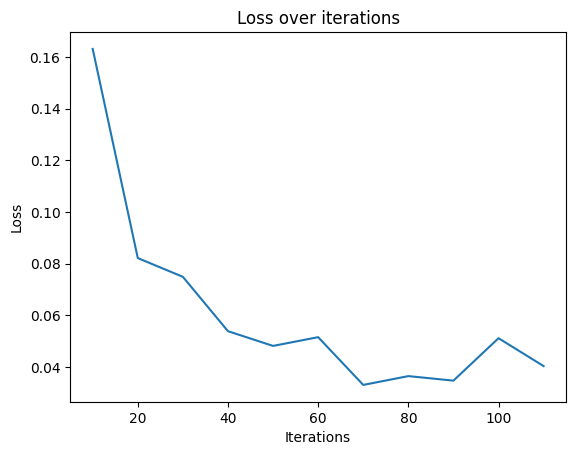

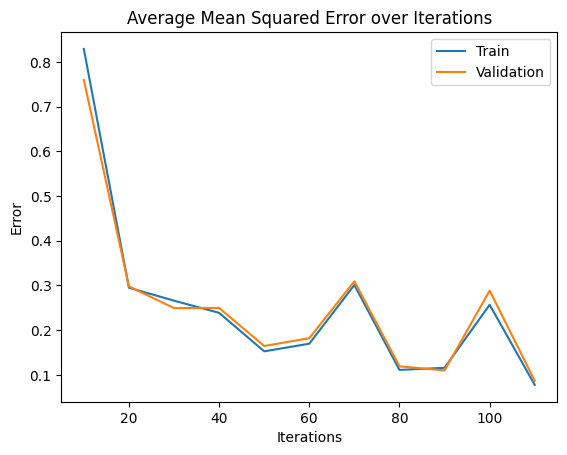

In [ ]:
# Note: Batch normalization works best on large batch sizes.
#       Batch normalization does not work on a batch size of 1.

train_model(model, train_data, val_data,
            learning_rate=0.001,
            batch_size=150,
            num_epochs=10,
            plot_every=10,
            clip_grad=1,
            alpha=0.01)

# batch_size param should be the same as that of train_model model
print("Final MSE on small training set: {0}", error(model, train_data, batch_size=150))

# Hyperparameter Tuning

Training with lr=0.001, batch_size=64, alpha=0.0, clip_grad=1


<ipython-input-19-0e6599d9afc9>:41: FutureWarning: `torch.nn.utils.clip_grad_norm` is now deprecated in favor of `torch.nn.utils.clip_grad_norm_`.
  torch.nn.utils.clip_grad_norm(model.parameters(), clip_grad)


10 Loss: 0.048781849443912506 Train Error: 0.15070403482776282 Val Error: 0.14790970121306934
20 Loss: 0.03564296290278435 Train Error: 0.05944016561319763 Val Error: 0.06891962259979312
30 Loss: 0.03843260556459427 Train Error: 0.05786967099528182 Val Error: 0.08229233826942371
40 Loss: 0.07512171566486359 Train Error: 0.042601351082143815 Val Error: 0.06219546859405963
50 Loss: 0.02797665260732174 Train Error: 0.010698387077740623 Val Error: 0.017058031278451853
60 Loss: 0.018481237813830376 Train Error: 0.010119060026113747 Val Error: 0.01269725504620322
70 Loss: 0.0194610096514225 Train Error: 0.02126939216894763 Val Error: 0.031193124355170233
80 Loss: 0.03502652794122696 Train Error: 0.016338071841916414 Val Error: 0.01750027254166731
90 Loss: 0.04816654324531555 Train Error: 0.022987012231105365 Val Error: 0.024635956876008447
100 Loss: 0.024959048256278038 Train Error: 0.020319490487995844 Val Error: 0.03250304031474837
110 Loss: 0.010326588526368141 Train Error: 0.011583954727

<ipython-input-19-0e6599d9afc9>:61: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


10 Loss: 0.1231435164809227 Train Error: 0.8438965112242656 Val Error: 0.7709469980206983
20 Loss: 0.05280659347772598 Train Error: 1.747420148211772 Val Error: 1.540929404940185
30 Loss: 0.05443187057971954 Train Error: 0.26610190623799357 Val Error: 0.2758691615756901
40 Loss: 0.052334316074848175 Train Error: 0.016753007857678148 Val Error: 0.022391978308729743
50 Loss: 0.030241912230849266 Train Error: 0.01354976675747738 Val Error: 0.018629137440887903
60 Loss: 0.014796680770814419 Train Error: 0.02737393218537051 Val Error: 0.03163209125057034
70 Loss: 0.023203887045383453 Train Error: 0.020026673168215707 Val Error: 0.022508708167806896
80 Loss: 0.02576538175344467 Train Error: 0.01029648289797788 Val Error: 0.015661778215718566
90 Loss: 0.021299762651324272 Train Error: 0.05021981143344499 Val Error: 0.04858117817519268
100 Loss: 0.01783098839223385 Train Error: 0.030774607037202566 Val Error: 0.040620988270560446
110 Loss: 0.019674992188811302 Train Error: 0.03674888513461435 

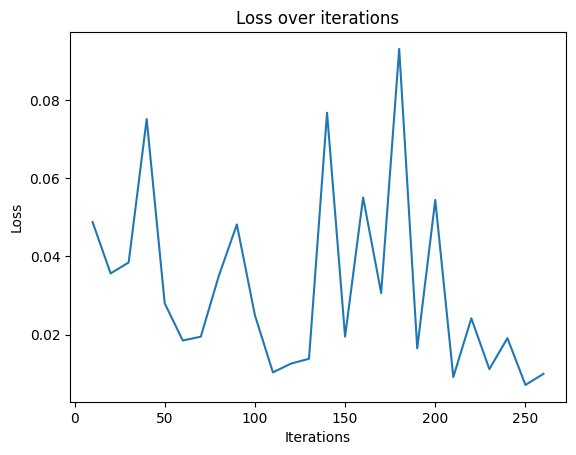

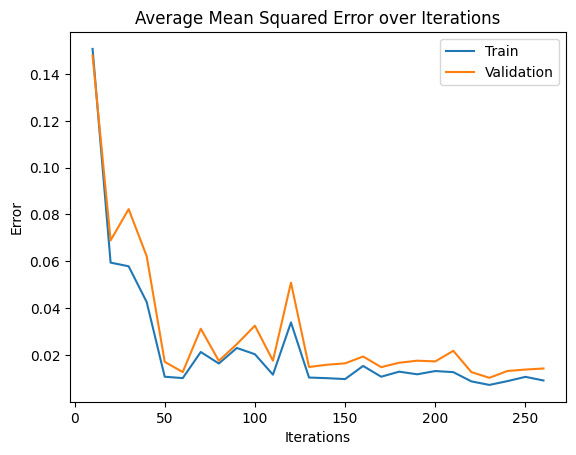

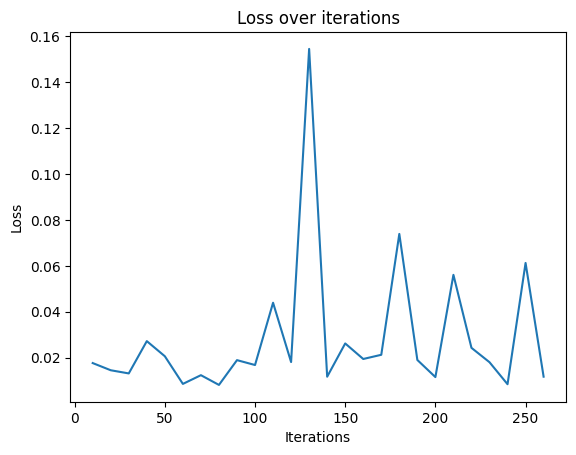

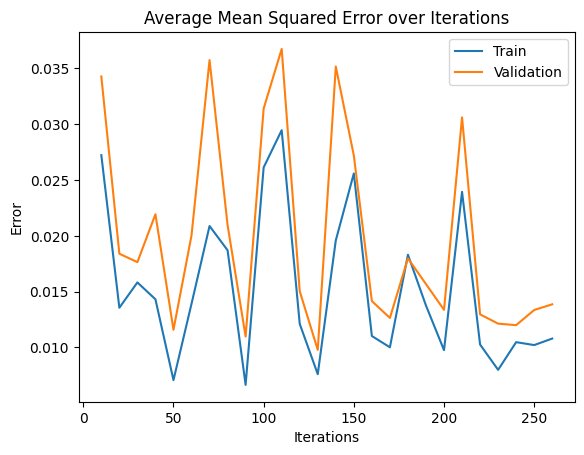

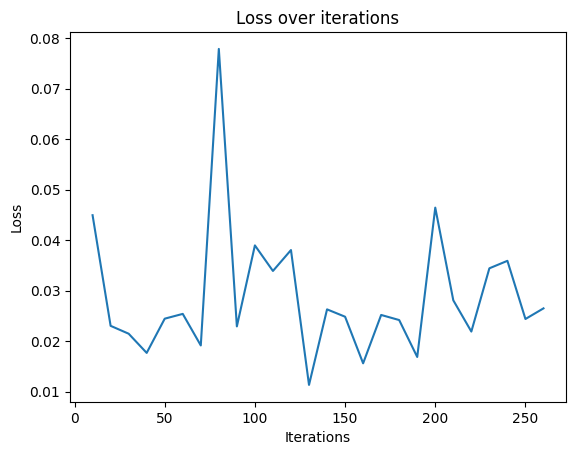

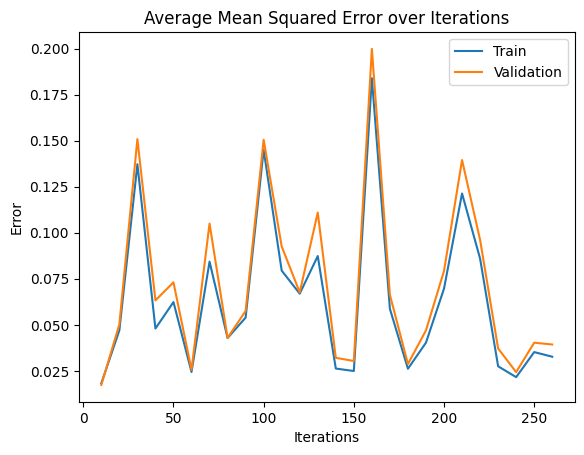

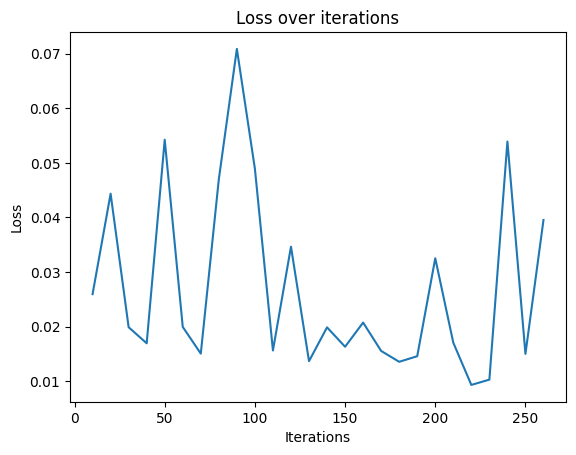

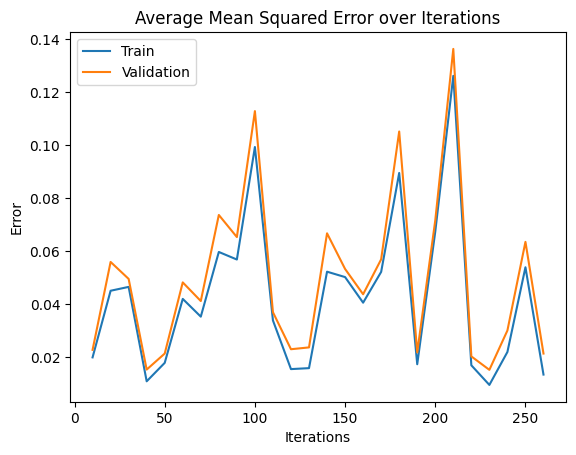

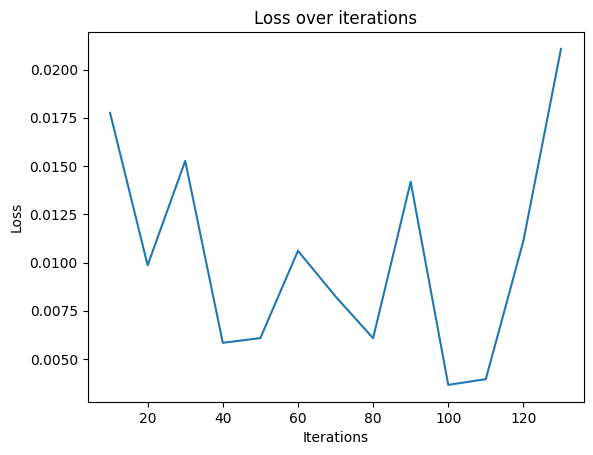

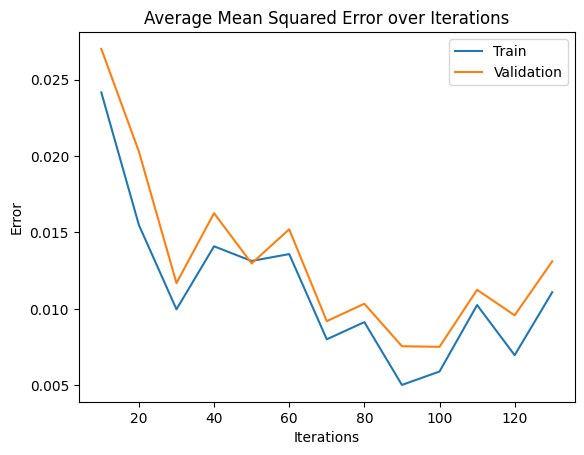

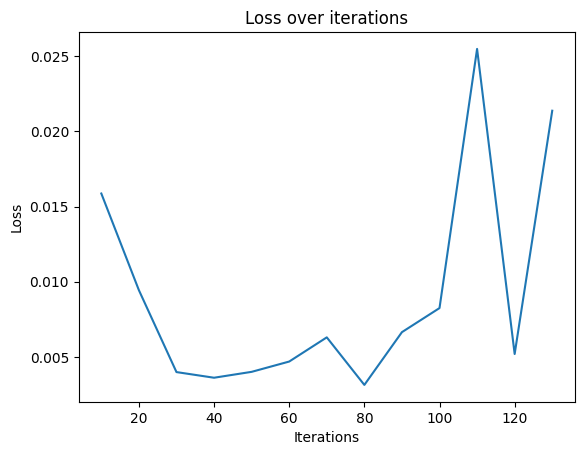

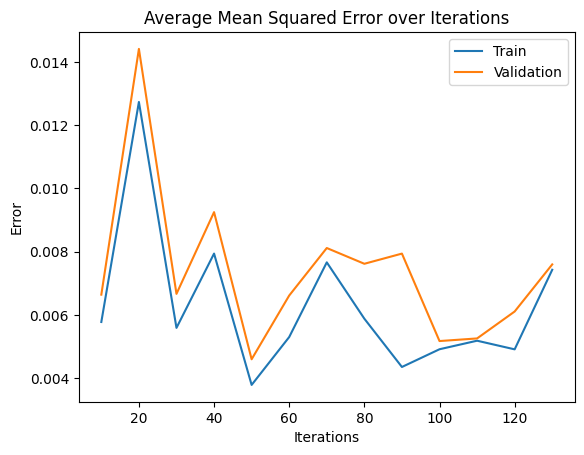

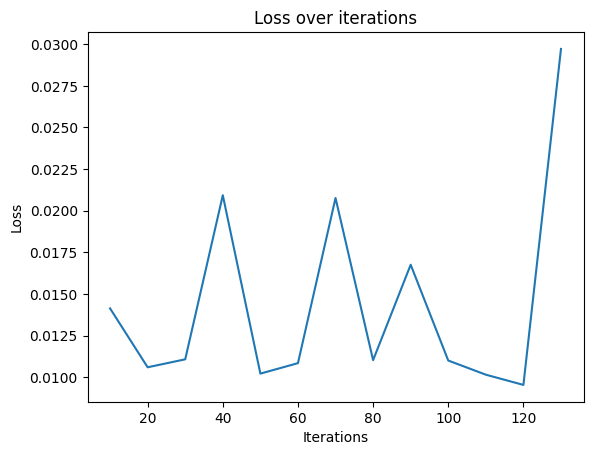

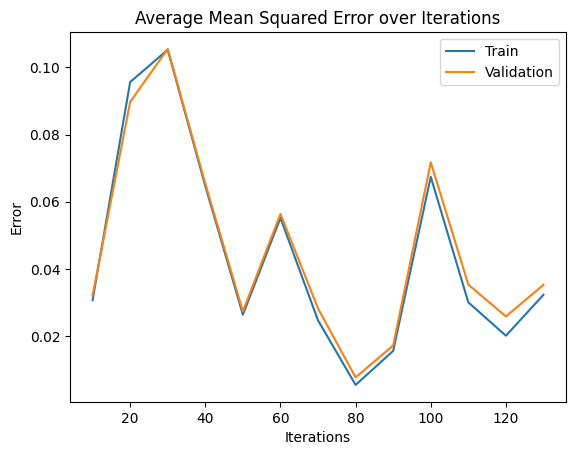

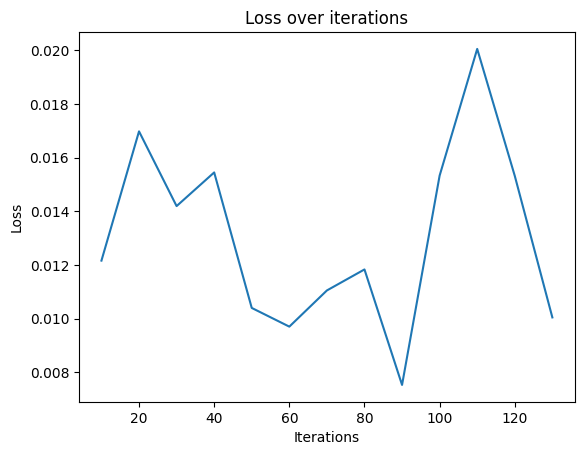

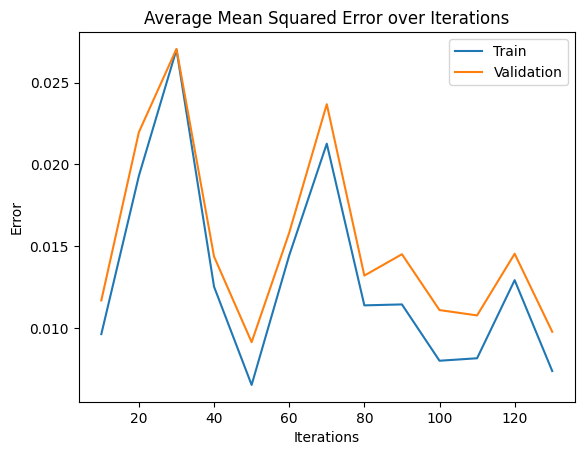

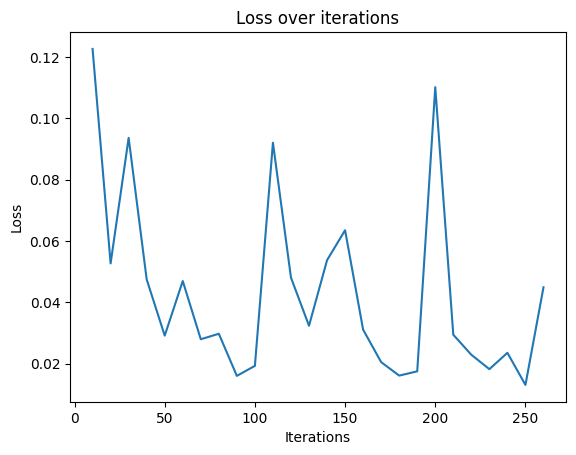

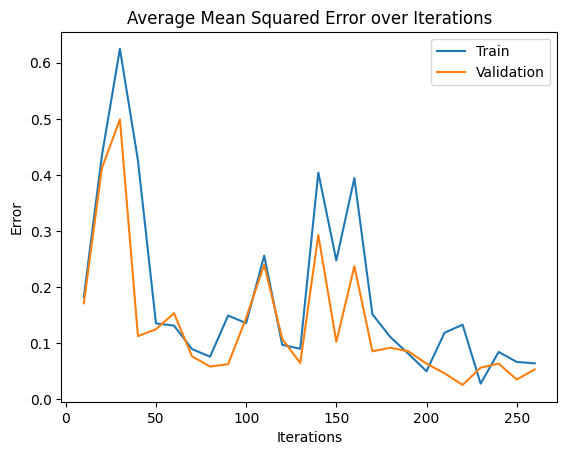

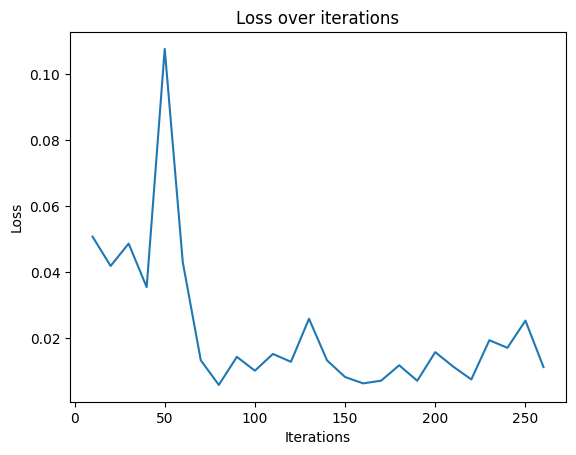

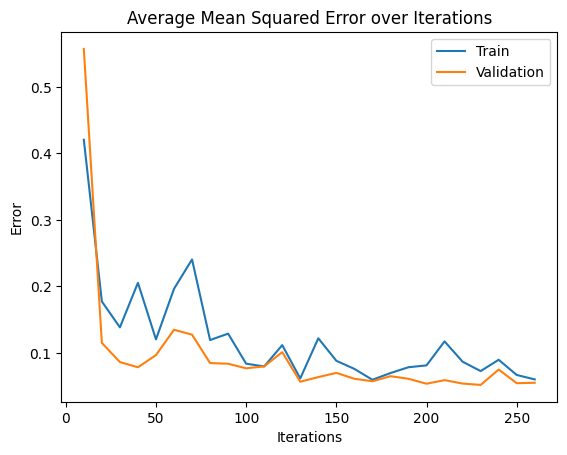

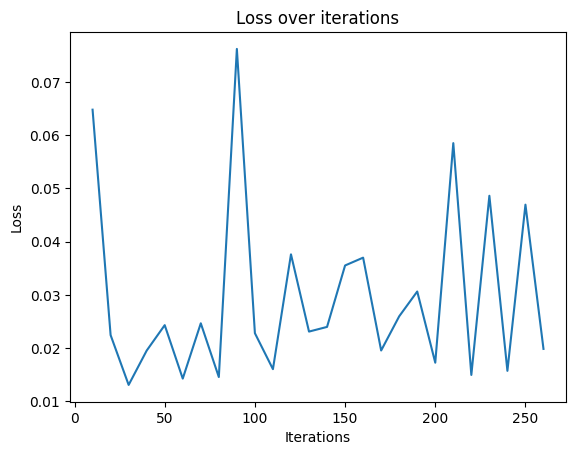

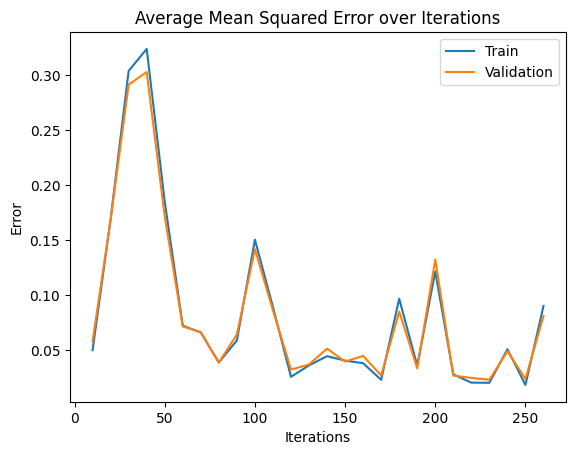

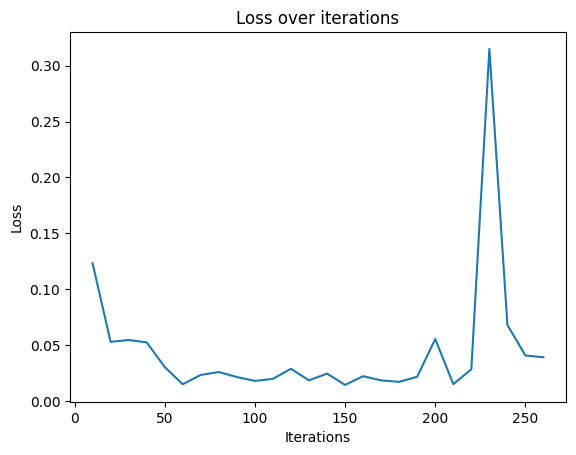

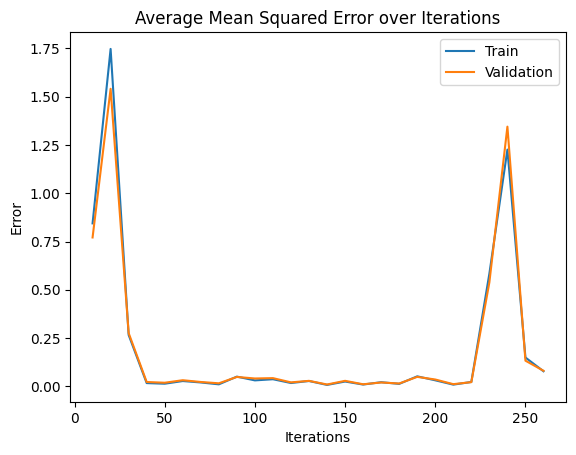

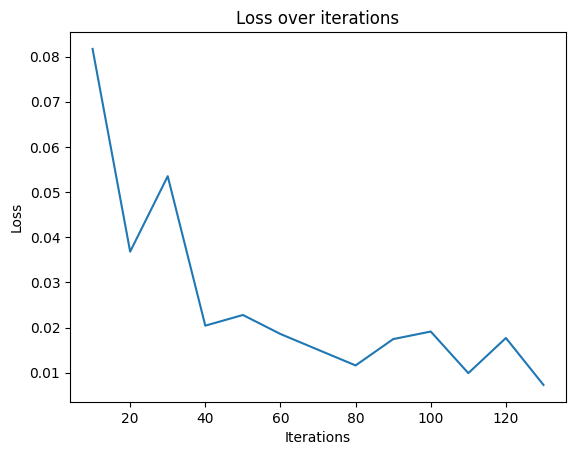

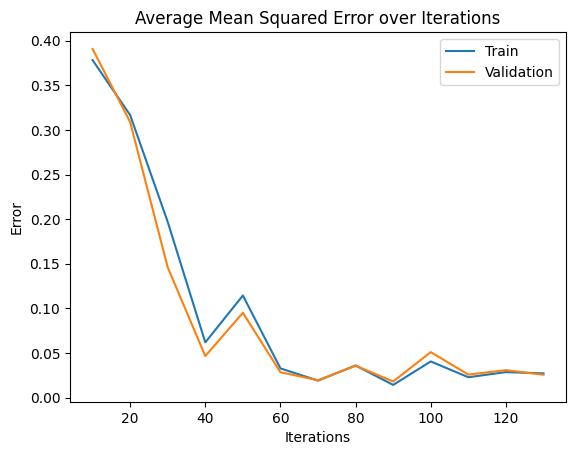

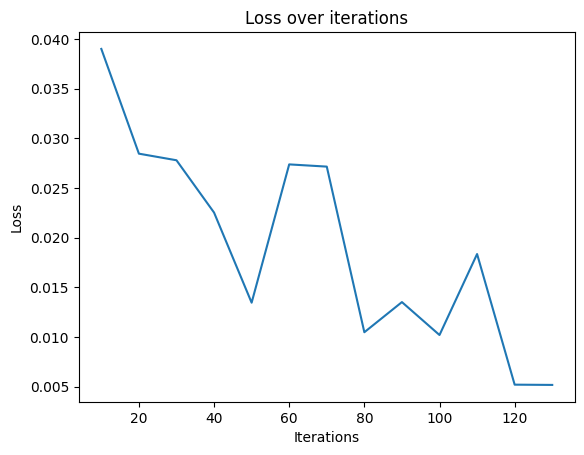

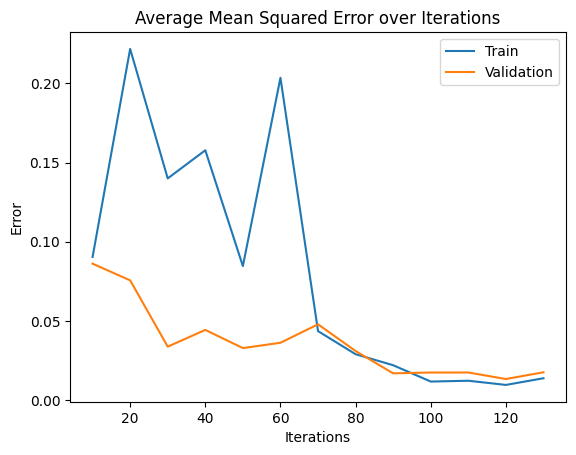

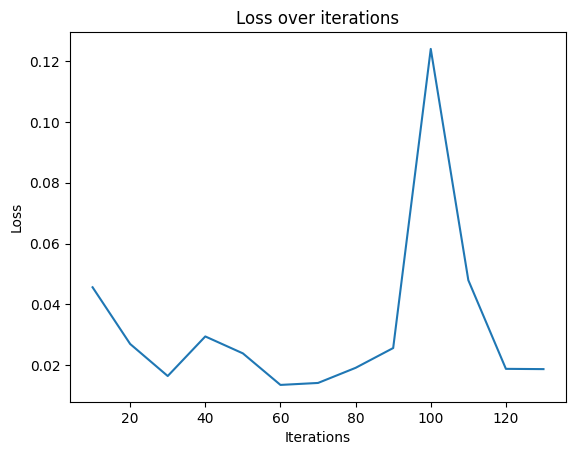

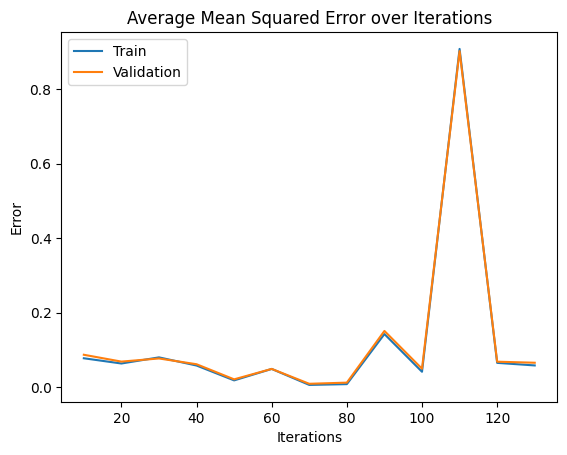

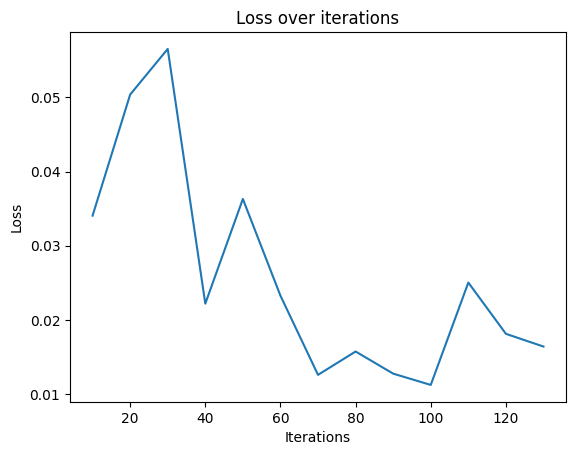

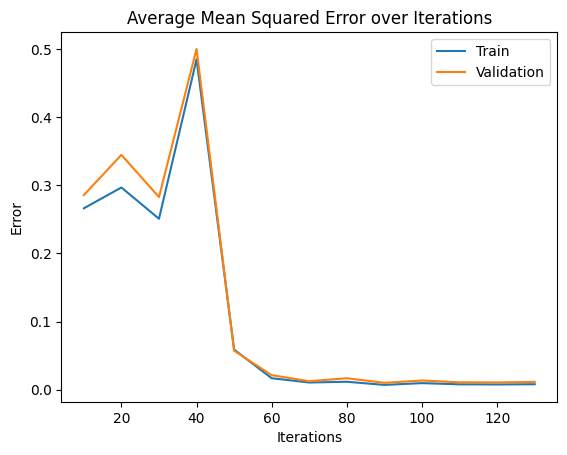

In [ ]:
from itertools import product
import pandas as pd
results = []

# Hyperparameter ranges
learning_rates = [0.001, 0.01]
batch_sizes = [64, 128]
alphas = [0.0, 0.01]
clip_grads = [1, None]

# All the combinations
for lr, batch_size, alpha, clip_grad in product(learning_rates, batch_sizes, alphas, clip_grads):
    print(f"Training with lr={lr}, batch_size={batch_size}, alpha={alpha}, clip_grad={clip_grad}")
    train_model(model, train_data, val_data,
                learning_rate=lr,
                batch_size=batch_size,
                num_epochs=10,
                plot_every=10,
                clip_grad=clip_grad,
                alpha=alpha)

    # Evaluate final validation error
    final_val_error = error(model, val_data, batch_size)

    # Store results
    results.append({
        "learning_rate": lr,
        "batch_size": batch_size,
        "alpha": alpha,
        "clip_grad": clip_grad,
        "val_error": final_val_error
    })

results_df = pd.DataFrame(results)

In [ ]:
sorted_results = results_df.sort_values(by="val_error")
print("Best Hyperparameters:")
print(sorted_results.iloc[0])
print(sorted_results)

Best Hyperparameters:
learning_rate      0.001000
batch_size       128.000000
alpha              0.000000
clip_grad               NaN
val_error          0.046717
Name: 5, dtype: float64
    learning_rate  batch_size  alpha  clip_grad  val_error
5           0.001         128   0.00        NaN   0.046717
4           0.001         128   0.00        1.0   0.047571
13          0.010         128   0.00        NaN   0.048558
7           0.001         128   0.01        NaN   0.050280
12          0.010         128   0.00        1.0   0.052752
10          0.010          64   0.01        1.0   0.054911
1           0.001          64   0.00        NaN   0.056197
6           0.001         128   0.01        1.0   0.057226
15          0.010         128   0.01        NaN   0.057529
0           0.001          64   0.00        1.0   0.057978
3           0.001          64   0.01        NaN   0.058375
8           0.010          64   0.00        1.0   0.061587
9           0.010          64   0.00        NaN

# Generalization & Results

In [ ]:
from torch.utils.data import DataLoader
import numpy as np

test_mse = error(model, test_data, batch_size=128) # Best batch size
print(f"Final Test MSE: {test_mse}")

test_loader = DataLoader(test_data, batch_size=128, shuffle=False)

predictions = []
truths = []

model.eval()

with torch.no_grad():
    for x_vis, x_stat, y_truth in test_loader:
        x_vis, x_stat, y_truth = x_vis.to(device), x_stat.to(device), y_truth.to(device)
        y_pred = model(x_vis, x_stat)
        predictions.append(y_pred.cpu().numpy())
        truths.append(y_truth.cpu().numpy())

all_predictions = np.concatenate(predictions, axis=0)
all_truths = np.concatenate(truths, axis=0)

print("Predictions vs Truths:")
for i in range(len(all_predictions)):
  print(f"Prediction: {all_predictions[i]}, Truth: {all_truths[i]}")

Final Test MSE: 0.009953564239872826
Predictions vs Truths:
Prediction: [-1.0334294   1.1161605  -0.08589321], Truth: [-0.9785437   1.020157   -0.04161332]
Prediction: [-0.9365554   1.2033862  -0.26733282], Truth: [-0.8233501  1.1127963 -0.2894461]
Prediction: [-0.9507709   0.5335501   0.40864706], Truth: [-1.153675    0.53470075  0.6189743 ]
Prediction: [-1.1457256   0.7163449   0.41999578], Truth: [-1.1267656   0.7820139   0.34475166]
Prediction: [-0.9722362   1.1770545  -0.20626912], Truth: [-0.8688337   1.0930867  -0.22425306]
Prediction: [-1.0932178  0.8982122  0.187897 ], Truth: [-1.0462614   0.9462179   0.10004353]
Prediction: [-0.98432994  1.169125   -0.18647933], Truth: [-0.9072116   1.0722537  -0.16504234]
Prediction: [-1.0603878   0.6006091   0.45016313], Truth: [-1.1441015   0.7072316   0.43686998]
Prediction: [-1.1047132   0.6657417   0.42935306], Truth: [-1.1387104   0.7351986   0.40351185]
Prediction: [-1.1110889   0.93510884  0.16922885], Truth: [-1.1296215   0.77209425

## **Visualization**

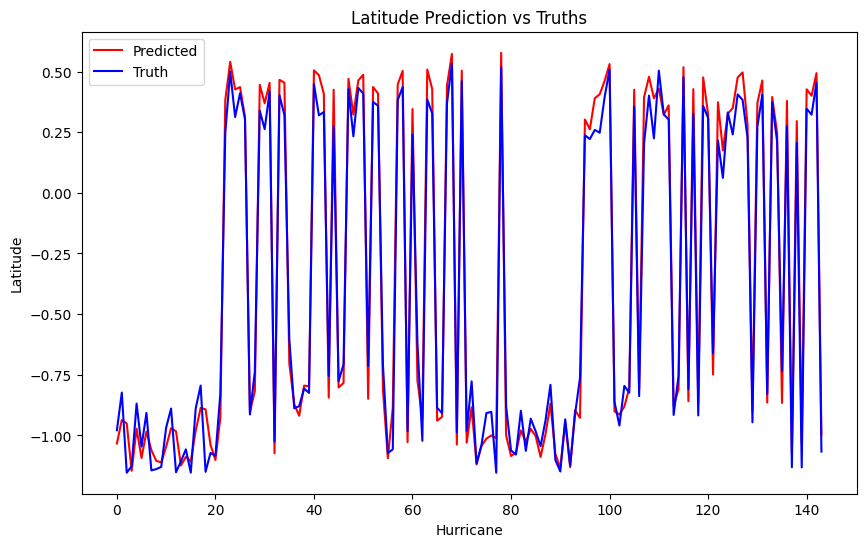

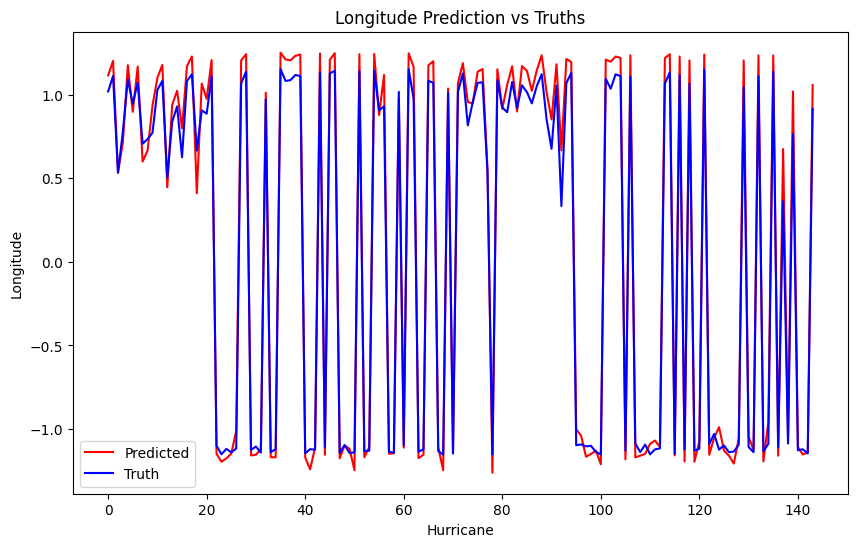

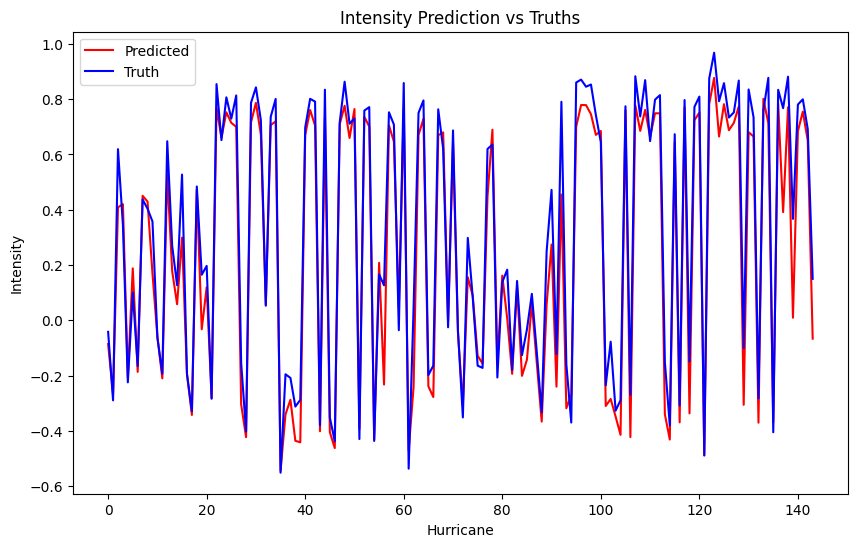

In [ ]:
import matplotlib.pyplot as plt

pred_lat, pred_lon, pred_intensity = all_predictions[:, 0], all_predictions[:, 1], all_predictions[:, 2]
truth_lat, truth_lon, truth_intensity = all_truths[:, 0], all_truths[:, 1], all_truths[:, 2]

# Latitude Comparison
plt.figure(figsize=(10, 6))
plt.plot(pred_lat, label='Predicted', color='red')
plt.plot(truth_lat, label='Truth', color='blue')
plt.title("Latitude Prediction vs Truths")
plt.xlabel("Hurricane")
plt.ylabel("Latitude")
plt.legend()
plt.show()

# Longitude Comparison
plt.figure(figsize=(10, 6))
plt.plot(pred_lon, label='Predicted', color='red')
plt.plot(truth_lon, label='Truth', color='blue')
plt.title("Longitude Prediction vs Truths")
plt.xlabel("Hurricane")
plt.ylabel("Longitude")
plt.legend()
plt.show()

# Intensity Comparison
plt.figure(figsize=(10,6))
plt.plot(pred_intensity, label='Predicted', color='red')
plt.plot(truth_intensity, label='Truth', color='blue')
plt.title("Intensity Prediction vs Truths")
plt.xlabel("Hurricane")
plt.ylabel("Intensity")
plt.legend()
plt.show()

In [ ]:
!pip install haversine

In [ ]:
# Load the mean and std to revert normalized prediction to actual values
mean = torch.load("mean.pt", weights_only=True)[1906:]
std = torch.load("std.pt", weights_only=True)[1906:]

In [ ]:
from haversine import haversine

# Record metrics for operational forecast models and HurriNet model
model.eval()
dataloader = DataLoader(test_data, batch_size=1)
total_MAE = 0
total_MGDE = 0
mae_loss = nnet.L1Loss

for i, (hurricane, x_stat, label) in enumerate(dataloader):
    z = model(hurricane, x_stat)

    # Denormalize the prediction and the label
    z_denorm = (z * std[i]) + mean[i]
    label_denorm = (label * std[i]) + mean[i]

    total_MAE += torch.mean(torch.abs(z_denorm[0, -1] - label_denorm[0, -1]))
    total_MGDE += haversine(z[0, :2].cpu().detach().numpy(), label[0, :2].cpu().detach().numpy())

print(f"Average MAE: {total_MAE / len(test_data)}")
print(f"Average MGDE: {total_MGDE / len(test_data)}")